# Benchmark Analysis - H7

In [292]:
import sys
!{sys.executable} -m pip install -r requirements.txt


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [293]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statistics
import os
from pathlib import Path
from typing import List, Dict, Any, Tuple, Optional

%matplotlib inline

In [294]:
matplotlib.style.use('seaborn-v0_8')  

In [295]:
device_name = 'nebulac'
core_list = [1,2,4,8,16,32,64]

In [296]:
root_dir = '/Users/diego/Desktop/BENCHMARK_NEBULAC_ALL_67M_WITH_BYTES'

In [297]:
GCC_TBB_COLOR           = 'salmon'
GCC_TBB_COLOR_SECONDARY = 'sienna'
GCC_TBB_COLOR_TERTIARY  = 'tomato'

NVC_OMP_COLOR           = 'green'
NVC_OMP_COLOR_SECONDARY = 'yellowgreen'
NVC_OMP_COLOR_TERTIARY  = 'aquamarine'

NVC_GPU_COLOR = 'beige'

In [298]:
plot_save_dir = './plots/h7'

## Utils 

In [299]:
def get_path(*entries):
    return os.path.join(*entries)

In [300]:
def ensure_file_existence(output_filename):
    """
    Checks wheterh the path to the file exists. If not it creates the folder structure and the final file.
    :param output_filename: path to the file
    :return:
    """

    # creates dirs etc if they do not exists
    output_path = Path(output_filename)
    if not os.path.exists(output_path.parent):
        os.makedirs(output_path.parent)
    output_path.touch(exist_ok=True)  # will create file, if it exists will do nothing

In [301]:
def plot(name:str,save=True) -> None:
    name = name.replace(' ','-')
    if save:
        plt.savefig(get_path(plot_save_dir,name+".png"),bbox_inches='tight')
    plt.show()

In [302]:
def extraction_pandas_frame_algo(path, COMP="TODO",include_bytes_per_second=False):
    df = pd.read_csv(path)

    # dropping columns we do not care about
    df = df.drop(['iterations', 'items_per_second', 'label', 'error_occurred', 'error_message'],
                 axis=1)
    
    if not include_bytes_per_second:
        df = df.drop(columns=['bytes_per_second'])

    # adding the problem size as column
    df = df[df['name'].str.endswith(('mean', 'median', 'stddev'))]
    df['n'] = df.apply(lambda x: x[0][x[0].find('/') + 1:x[0].rfind('_')], axis=1)

    df = df.reset_index(drop=True)

    # convert to format 
    # name	real_time	cpu_time	time_unit	n	median	stddev	Compiler
    results_gcc = df.groupby('n').apply(lambda sf: pd.Series(sf.iloc[0])).reset_index(drop=True)
    results_gcc.n = results_gcc.n.astype(int)
    results_gcc = results_gcc.sort_values(['n'], ascending=True).reset_index(drop=True)

    results_gcc['C'] = np.arange(len(results_gcc))

    results_gcc['median_id'] = results_gcc['C'] * 3 + 1
    results_gcc['median'] = results_gcc['median_id'].apply(lambda x: df.iloc[x]['real_time'])

    results_gcc['stddev_id'] = results_gcc['C'] * 3 + 2
    results_gcc['stddev'] = results_gcc['stddev_id'].apply(lambda x: df.iloc[x]['real_time'])

    results_gcc = results_gcc.drop(['C', 'median_id', 'stddev_id'], axis=1)
    results_gcc['Compiler'] = COMP
    results_gcc['name'] = results_gcc.apply(lambda x: x[0].replace(str(x['n']), "").replace('/_mean', ''), axis=1)

    return results_gcc


In [303]:
# generate filename for threading
def get_threading_file_name(benchmark_name:str, thread_nr: int, input_size:str) -> str:
    return f"[T{thread_nr}]_{benchmark_name}_{input_size}_T{thread_nr}.csv"

# extract threaded into dictionary
def extraction_pandas_frame_algo_threaded(folder_path:str, benchmark_name:str, threads_list:List[int], input_size:int = '67108864', COMP:str="TODO") -> Any:
    result = pd.DataFrame()

    for t_id in threads_list:
        filename = get_threading_file_name(benchmark_name=benchmark_name,thread_nr=t_id,input_size=input_size)
        file_path = get_path(folder_path,filename)
        
        data_frame = extraction_pandas_frame_algo(file_path,COMP=COMP)
        data_frame['threads'] = t_id
        result = pd.concat([result, data_frame], ignore_index=True)


    result = result.rename_axis(None, axis=1)
    return result

In [304]:
# calculate speedup based on seq runnings
def calc_speedup_based_seq(seq_df: pd.DataFrame, threads_df: pd.DataFrame, speedup_column_name:str, input_size:int = 67108864) -> pd.DataFrame:
    # calculate speedup
    seq_df = seq_df[seq_df['n'] == input_size]
    seq_time = seq_df['real_time'].iloc[0] # now its only a single digit

    threads_df['speedup'] = seq_time / threads_df['real_time'] 

    # clean df
    threads_df = threads_df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler','n','real_time'])
    threads_df = threads_df.rename(columns={'speedup':speedup_column_name})

    return threads_df

In [305]:
def calc_speedup_based_par(threads_df: pd.DataFrame, speedup_column_name:str, input_size:int = 67108864) -> pd.DataFrame:
    base_time = threads_df[threads_df['threads'] == 1].iloc[0]['real_time']
    
    threads_df['speedup'] = base_time / threads_df['real_time'] 

    # clean df
    threads_df = threads_df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler','n','real_time'])
    threads_df = threads_df.rename(columns={'speedup':speedup_column_name})

    return threads_df

In [306]:
def par_data_algo(compiler_location:str,compiler_name:str,bench_name:str) -> pd.DataFrame:
    # load bench_name
    df = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/{bench_name}_par__Default.csv',COMP=compiler_name)

    df = df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler'])
    df = df.rename(columns={'real_time':f'{compiler_name}'})

    return df

In [307]:
def get_seq_base(benchmark_name:str) -> pd.DataFrame:

    time_filed_name = 'real_time'

    compiler_instances = [
        ('GCC_TBB','GCC(TBB)'),
        ('NVHPC_Multicore','NVC(OMP)')
    ]

    start_df = extraction_pandas_frame_algo(f'{root_dir}/{compiler_instances[0][0]}/DEFAULT/{benchmark_name}_seq__Default.csv')
    min_val = start_df[time_filed_name].min()
    min_df = start_df


    for i in range(1,len(compiler_instances)):
        current_df = extraction_pandas_frame_algo(f'{root_dir}/{compiler_instances[i][0]}/DEFAULT/{benchmark_name}_seq__Default.csv')
        current_min = current_df[time_filed_name].min()

        if current_min < min_val:
            min_val = current_min
            min_df = current_df

    return min_df

In [308]:
def get_strong_scaling_algo(compiler_location:str,
                            compiler_name:str,
                            bench_name:str,
                            base_of:Optional[str] = None) -> pd.DataFrame:
    
    seq_base = None

    if base_of:
        # base it of a other file and not the own sec
        seq_base = get_seq_base(base_of)
    else:
        ## seq base
        seq_base = get_seq_base(bench_name)
    
    ## threaded
    df = extraction_pandas_frame_algo_threaded(f'{root_dir}/{compiler_location}/THREADS',
                                               f'{bench_name}_par',
                                               core_list,
                                               COMP=compiler_name
                                               )

    ## calc strong scaling
    return calc_speedup_based_seq(seq_base,df,f"{compiler_name}")

In [309]:
def bytes_per_second_data_algo(compiler_location:str,compiler_name:str,benchmark_name:str,exec_suffix:str='par') -> pd.DataFrame:
    # load b4_2_stable_sort_cutoff_decrement_sorted_par
    df = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/{benchmark_name}_{exec_suffix}__Default.csv',COMP=compiler_name,include_bytes_per_second=True)

    df = df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler','real_time'])

    # calc  Mbytes/s
    df[f'{compiler_name}'] = df['bytes_per_second'] * pow(10,-6) # 
    df = df.drop(columns=['bytes_per_second'])
    
    return df

# H7
> Employing specific parallel algorithms tends to yield superior performance/strong scaling compared to utilizing custom
> implementations that rely on various other parallel algorithm functions.


## `b7_1` copy logic

In [310]:
benchmark_names = [
    ("b7_1_copy",'std::copy'),
    ("b7_1_custom_copy_with_foreach",'std::foreach')
]

strong_scale_base = 'b7_1_copy'


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - copy logic

Check how the runtime without constraining the threads develops with increasing input size

In [311]:
# collect data for instances
data = [
    par_data_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name 
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]

# merge for plotting
b7_1_time_merged = data[0]

for i in range(1,len(data)):
    b7_1_time_merged = pd.merge(b7_1_time_merged,data[i], on='n')

b7_1_time_merged

,GCC(TBB) - std::copy,n,GCC(TBB) - std::foreach,NVC(OMP) - std::copy,NVC(OMP) - std::foreach
0,6167.07,4,2.629210e+02,11488.8,10618.2
1,10046.60,8,2.637950e+02,11271.6,11111.2
2,16687.90,16,2.655990e+02,11138.6,11637.1
3,21295.10,32,2.697700e+02,12536.4,12433.4
4,23850.00,64,2.765650e+02,14804.3,14117.6
5,27552.20,128,2.869730e+02,14197.5,13292.8
6,29214.80,256,3.212110e+02,12095.3,13580.3
7,33008.50,512,3.653590e+02,12020.4,14025.8
8,36225.30,1024,4.518460e+02,14128.9,14667.3
9,40468.40,2048,6.213010e+02,13478.7,12872.8


### Strong Scaling - copy logic
 
2^26 fixed input size with threads 1-64

In [312]:
# collect data for instances
data = [
    get_strong_scaling_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name,
                  base_of=strong_scale_base
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]


# merge for plotting
b7_1_strong_scaling_merged = data[0]

for i in range(1,len(data)):
    b7_1_strong_scaling_merged = pd.merge(b7_1_strong_scaling_merged,data[i], on='threads')


b7_1_strong_scaling_merged

,threads,GCC(TBB) - std::copy,GCC(TBB) - std::foreach,NVC(OMP) - std::copy,NVC(OMP) - std::foreach
0,1,0.681363,0.674555,0.106621,0.068865
1,2,0.841616,0.675055,0.212323,0.137361
2,4,0.837207,0.676951,0.421590,0.266511
3,8,0.695862,0.675414,0.471975,0.351520
4,16,0.755991,0.674229,0.527100,0.486432
5,32,0.708635,0.674415,0.543997,0.546439
6,64,0.677620,0.675382,0.544331,0.530327


In [313]:
## efficiency graph

b7_1_efficiency = b7_1_strong_scaling_merged.copy()

for _,compiler_name in instances:
    for bench_name, display_name in benchmark_names:
        b7_1_efficiency[f'{compiler_name} - {display_name}'] = b7_1_efficiency[f'{compiler_name} - {display_name}'] / b7_1_efficiency['threads']

b7_1_efficiency

,threads,GCC(TBB) - std::copy,GCC(TBB) - std::foreach,NVC(OMP) - std::copy,NVC(OMP) - std::foreach
0,1,0.681363,0.674555,0.106621,0.068865
1,2,0.420808,0.337528,0.106162,0.068681
2,4,0.209302,0.169238,0.105397,0.066628
3,8,0.086983,0.084427,0.058997,0.043940
4,16,0.047249,0.042139,0.032944,0.030402
5,32,0.022145,0.021075,0.017000,0.017076
6,64,0.010588,0.010553,0.008505,0.008286


### Mbytes/s

In [314]:
# collect data for instances

# collect data for instances
data = [
    bytes_per_second_data_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  benchmark_name=bench_name 
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]

# merge for plotting
b7_1_bytes_merged = data[0]

for i in range(1,len(data)):
    b7_1_bytes_merged = pd.merge(b7_1_bytes_merged,data[i], on='n')

b7_1_bytes_merged

,n,GCC(TBB) - std::copy,GCC(TBB) - std::foreach,NVC(OMP) - std::copy,NVC(OMP) - std::foreach
0,4,5.20729,120.864,2.75298,2.97176
1,8,6.23401,240.939,5.61549,5.65978
2,16,7.53033,478.600,11.38440,10.80020
3,32,11.83510,942.624,20.20140,20.12700
4,64,21.13270,1838.720,34.34330,35.36110
5,128,36.69680,3545.680,71.46650,74.95850
6,256,69.26910,6339.660,167.55400,146.86900
7,512,122.82500,11155.000,337.41500,283.92700
8,1024,224.07800,18060.000,575.37900,541.14800
9,2048,401.62700,26292.000,1210.60000,1239.45000


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_11879/2622965913.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


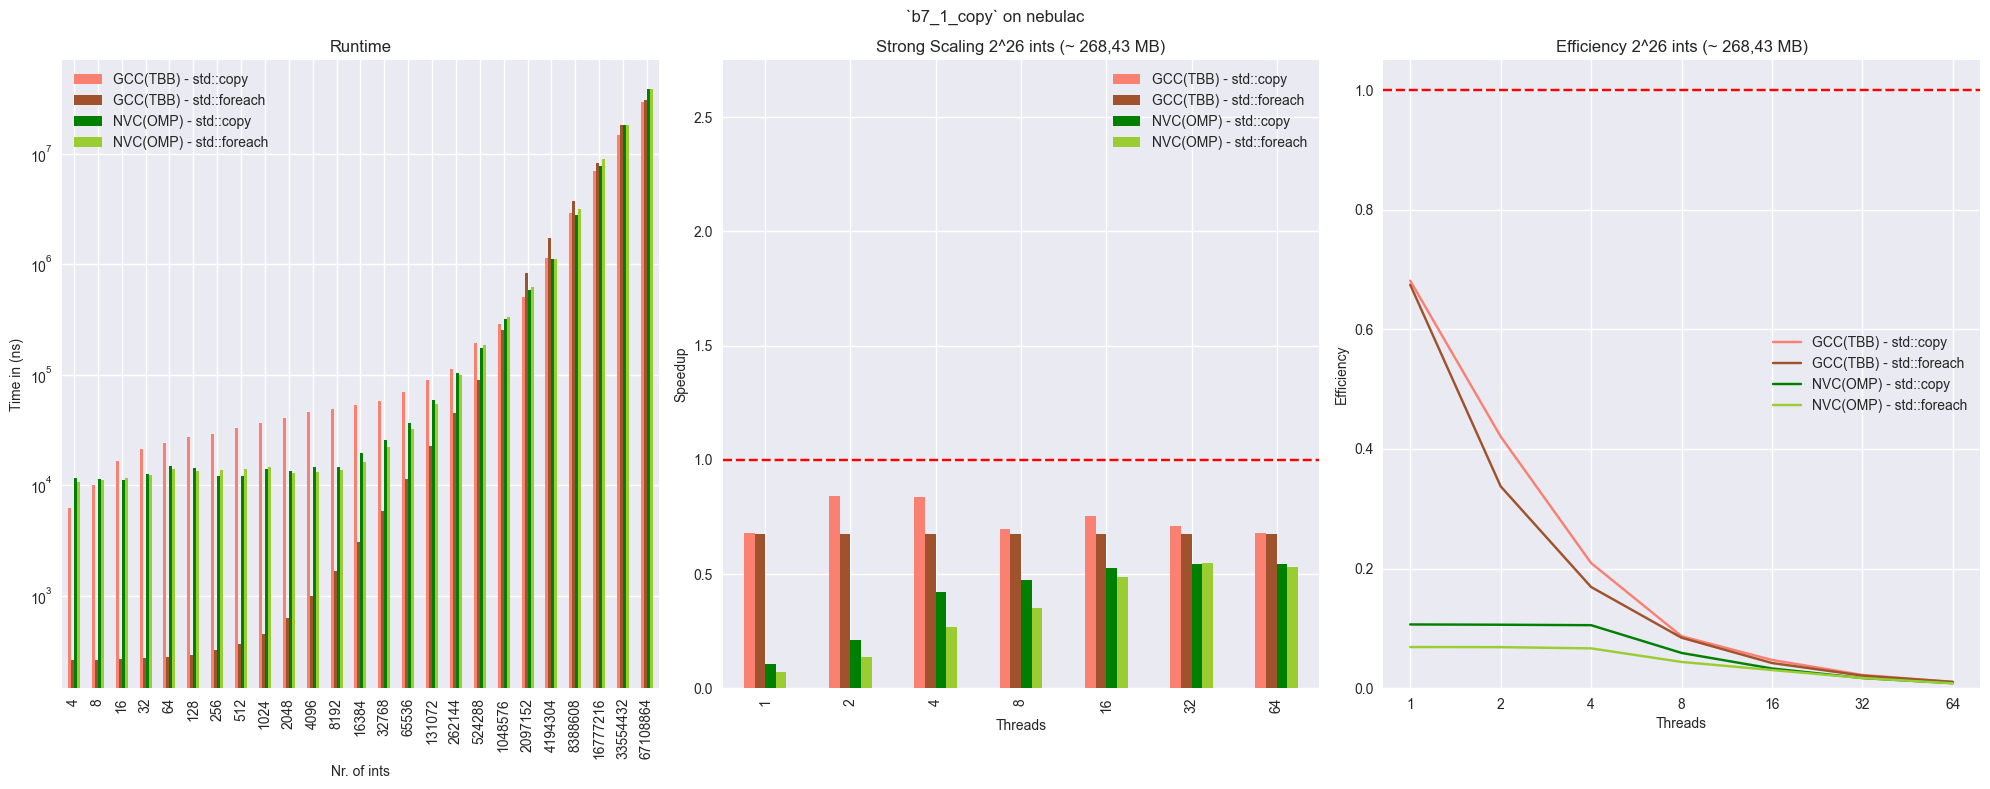

In [315]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(20, 8))


# plot runtime
ax_1 = b7_1_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY], ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=10)


# plot strong scaling
ax_2 = b7_1_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY],
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

ax_2.set_ylim(0,2.75)
ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')






# plot efficiency
ax_3 = b7_1_efficiency.plot(x='threads',
                                                            color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY],
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_ylim(0,1.05)

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')


fig.suptitle(f"`b7_1_copy` on {device_name}")

fig.tight_layout()

plot(f"`b7_1_copy` {device_name}")

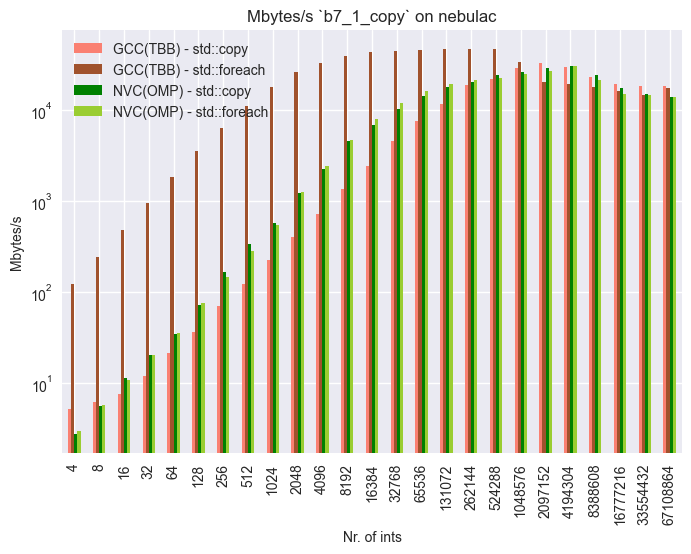

In [316]:
# mybtes graph


b7_1_bytes_merged.plot(kind='bar',
                       x='n',
                       color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]
                    )

plt.yscale('log',base=10)
plt.ylabel('Mbytes/s')
plt.xlabel('Nr. of ints')
plt.title(f'Mbytes/s `b7_1_copy` on {device_name}')


plot(f'`b7_1_copy` Mbytes_s on {device_name}')

## `b7_2` -  all_true

In [317]:
benchmark_names = [
    ("b7_2_all_of_all_true",'std::all_of'),
    ("b7_2_custom_all_of_with_transform_reduce_all_true",'std::transform_reduce')
]

strong_scale_base = 'b7_2_all_of_all_true'

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - all_true

Check how the runtime without constraining the threads develops with increasing input size

In [318]:
# collect data for instances
data = [
    par_data_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]

# merge for plotting
b7_2_time_merged = data[0]

for i in range(1,len(data)):
    b7_2_time_merged = pd.merge(b7_2_time_merged,data[i], on='n')

b7_2_time_merged

,GCC(TBB) - std::all_of,n,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,8285.48,4,4531.34,47007.7,24521.0
1,14207.10,8,7014.19,48708.7,24583.4
2,19772.60,16,11012.60,47955.9,24235.3
3,24434.70,32,15990.40,49025.2,25398.5
4,27896.00,64,20523.20,49516.9,26334.0
5,30094.00,128,24324.50,48200.9,26458.5
6,31115.20,256,26717.90,48423.0,26342.0
7,32954.60,512,28206.70,49035.6,26733.6
8,35251.00,1024,30514.10,49041.4,26112.9
9,39009.80,2048,34449.10,48699.7,26247.1


### Strong Scaling - all true
 
2^26 fixed input size with threads 1-64

In [319]:
# collect data for instances
data = [
    get_strong_scaling_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name,
                  base_of=strong_scale_base
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]


# merge for plotting
b7_2_strong_scaling_merged = data[0]

for i in range(1,len(data)):
    b7_2_strong_scaling_merged = pd.merge(b7_2_strong_scaling_merged,data[i], on='threads')


b7_2_strong_scaling_merged

,threads,GCC(TBB) - std::all_of,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,1,1.050178,0.824168,0.340803,0.447282
1,2,1.771641,1.438562,0.661108,0.874330
2,4,2.229823,2.123649,0.977840,1.392548
3,8,1.592956,1.829104,1.054397,1.167161
4,16,2.043933,1.933889,1.044386,1.368859
5,32,2.072204,2.239841,1.038605,1.046276
6,64,1.995652,1.974002,0.914940,1.141797


In [320]:
## efficiency graph

b7_2_efficiency = b7_2_strong_scaling_merged.copy()

for _,compiler_name in instances:
    for bench_name, display_name in benchmark_names:
        b7_2_efficiency[f'{compiler_name} - {display_name}'] = b7_2_efficiency[f'{compiler_name} - {display_name}'] / b7_2_efficiency['threads']

b7_2_efficiency

,threads,GCC(TBB) - std::all_of,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,1,1.050178,0.824168,0.340803,0.447282
1,2,0.885820,0.719281,0.330554,0.437165
2,4,0.557456,0.530912,0.244460,0.348137
3,8,0.199120,0.228638,0.131800,0.145895
4,16,0.127746,0.120868,0.065274,0.085554
5,32,0.064756,0.069995,0.032456,0.032696
6,64,0.031182,0.030844,0.014296,0.017841


### Mbytes/s

In [321]:
# collect data for instances

# collect data for instances
data = [
    bytes_per_second_data_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  benchmark_name=bench_name 
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]

# merge for plotting
b7_2_all_true_bytes_merged = data[0]

for i in range(1,len(data)):
    b7_2_all_true_bytes_merged = pd.merge(b7_2_all_true_bytes_merged,data[i], on='n')

b7_2_all_true_bytes_merged

,n,GCC(TBB) - std::all_of,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,4,1.96675,7.16003,0.339096,1.31995
1,8,2.23205,9.20491,0.653605,2.63099
2,16,3.20405,11.73960,1.336470,5.32948
3,32,5.18497,16.15990,2.595460,10.17810
4,64,9.08067,25.15910,5.137630,19.62640
5,128,16.82850,42.42530,10.538800,39.06670
6,256,32.57100,77.18980,20.983800,78.48550
7,512,61.61760,146.21800,41.446200,154.66200
8,1024,115.21100,270.28300,82.873200,316.82200
9,2048,208.84100,479.48000,166.904000,630.22600


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_11879/4199204651.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


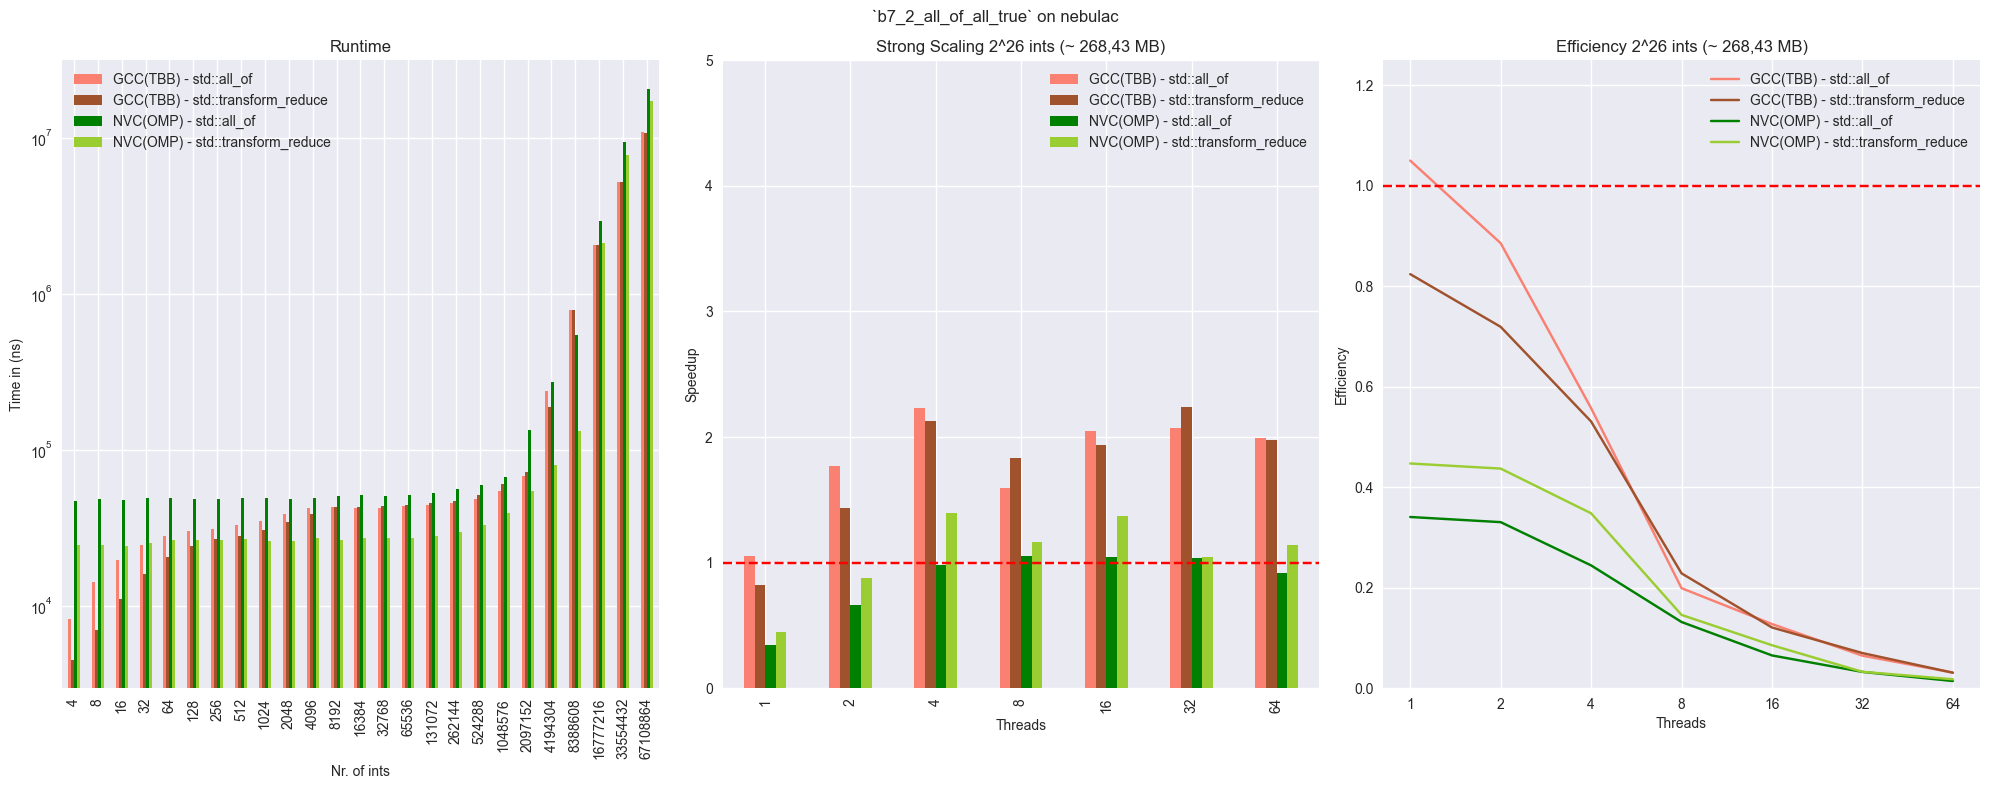

In [322]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(20, 8))


# plot runtime
ax_1 = b7_2_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY], ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=10)


# plot strong scaling
ax_2 = b7_2_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY],
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')
ax_2.set_ylim(0,5)





# plot efficiency
ax_3 = b7_2_efficiency.plot(x='threads',
                                                            color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY],
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_ylim(0,1.25)

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')


fig.suptitle(f"`b7_2_all_of_all_true` on {device_name}")

fig.tight_layout()

plot(f"`b7_2_all_of_all_true` {device_name}")

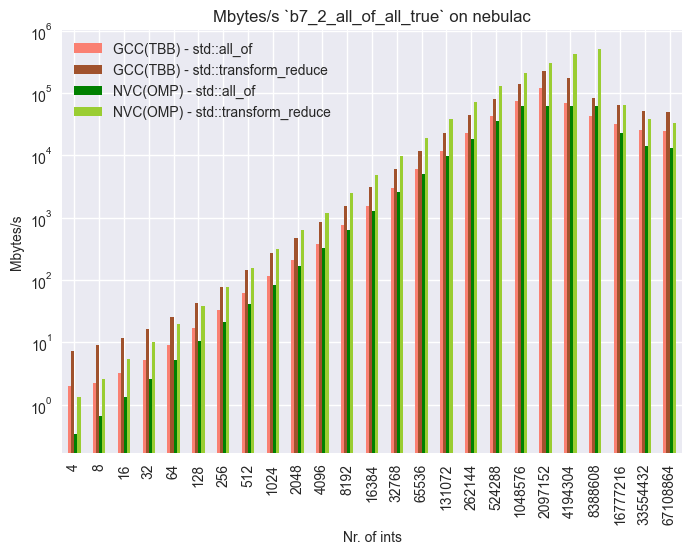

In [323]:
# mybtes graph


b7_2_all_true_bytes_merged.plot(kind='bar',
                       x='n',
                       color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]
                       )

plt.yscale('log',base=10)
plt.ylabel('Mbytes/s')
plt.xlabel('Nr. of ints')
plt.title(f'Mbytes/s `b7_2_all_of_all_true` on {device_name}')


plot(f'`b7_2_all_of_all_true` Mbytes_s on {device_name}')

## `b7_2` -  first_false

In [324]:
benchmark_names = [
    ("b7_2_all_of_first_false",'std::all_of'),
    ("b7_2_custom_all_of_with_transform_reduce_first_false",'std::transform_reduce')
]

strong_scale_base = 'b7_2_all_of_first_false'

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - first_false

Check how the runtime without constraining the threads develops with increasing input size

In [325]:
# collect data for instances
data = [
    par_data_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name 
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]

# merge for plotting
b7_2_first_false_time_merged = data[0]

for i in range(1,len(data)):
    b7_2_first_false_time_merged = pd.merge(b7_2_first_false_time_merged,data[i], on='n')

b7_2_first_false_time_merged

,GCC(TBB) - std::all_of,n,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,5474.56,4,5007.91,43959.4,23469.0
1,8602.28,8,7315.77,39682.6,22485.8
2,12120.30,16,11195.80,46196.9,23295.5
3,17618.50,32,16216.00,43751.0,23530.0
4,21787.60,64,20869.10,43885.9,24471.2
5,25157.60,128,24807.30,43891.5,24864.5
6,27850.40,256,26778.20,44771.8,24904.7
7,27809.60,512,28105.00,41749.0,25243.7
8,27841.60,1024,30431.20,41896.6,25110.4
9,27618.10,2048,33709.30,42567.3,24816.4


### Strong Scaling - first_false
 
2^26 fixed input size with threads 1-64

In [326]:
# collect data for instances
data = [
    get_strong_scaling_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name,
                  base_of=strong_scale_base
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]


# merge for plotting
b7_2_first_false_strong_scaling_merged = data[0]

for i in range(1,len(data)):
    b7_2_first_false_strong_scaling_merged = pd.merge(b7_2_first_false_strong_scaling_merged,data[i], on='threads')


b7_2_first_false_strong_scaling_merged

,threads,GCC(TBB) - std::all_of,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,1,0.270535,0.000010,0.000231,0.000006
1,2,0.055685,0.000019,0.000454,0.000011
2,4,0.025820,0.000019,0.000861,0.000015
3,8,0.022359,0.000020,0.001464,0.000015
4,16,0.012581,0.000025,0.002343,0.000019
5,32,0.012176,0.000028,0.002882,0.000016
6,64,0.011528,0.000024,0.003371,0.000015


In [327]:
## efficiency graph

b7_2_first_false_efficiency = b7_2_first_false_strong_scaling_merged.copy()

for _,compiler_name in instances:
    for bench_name, display_name in benchmark_names:
        b7_2_first_false_efficiency[f'{compiler_name} - {display_name}'] = b7_2_first_false_efficiency[f'{compiler_name} - {display_name}'] / b7_2_first_false_efficiency['threads']

b7_2_first_false_efficiency

,threads,GCC(TBB) - std::all_of,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,1,0.270535,1.011085e-05,0.000231,5.652279e-06
1,2,0.027843,9.468603e-06,0.000227,5.568962e-06
2,4,0.006455,4.768945e-06,0.000215,3.638107e-06
3,8,0.002795,2.489704e-06,0.000183,1.827029e-06
4,16,0.000786,1.572632e-06,0.000146,1.188896e-06
5,32,0.000380,8.784602e-07,0.000090,5.077830e-07
6,64,0.000180,3.748395e-07,0.000053,2.405171e-07


### Mbytes/s

In [328]:

# collect data for instances
data = [
    bytes_per_second_data_algo(compiler_location=comp_location,
                               compiler_name=f'{comp_name} - {display_name}',
                               benchmark_name=bench_name
                               )
    for comp_location, comp_name in instances
    for bench_name, display_name in benchmark_names
]

# merge for plotting
b7_2_first_false_bytes_merged = data[0]

for i in range(1,len(data)):
    b7_2_first_false_bytes_merged = pd.merge(b7_2_first_false_bytes_merged,data[i], on='n')

b7_2_first_false_bytes_merged

,n,GCC(TBB) - std::all_of,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,4,2.895540e+00,6.38219,3.685660e-01,1.37465
1,8,3.707990e+00,8.68744,8.027980e-01,2.87039
2,16,5.259330e+00,11.31660,1.400900e+00,5.52180
3,32,7.393290e+00,15.62050,2.919590e+00,10.92300
4,64,1.185190e+01,24.26700,5.824260e+00,21.12290
5,128,2.035570e+01,40.83470,1.164760e+01,41.56170
6,256,3.665310e+01,75.65470,2.296520e+01,82.99270
7,512,7.341650e+01,144.18100,4.896520e+01,163.62600
8,1024,1.467460e+02,266.49100,9.759560e+01,329.09500
9,2048,2.956660e+02,481.57300,1.924180e+02,666.20800


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_11879/1392981099.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


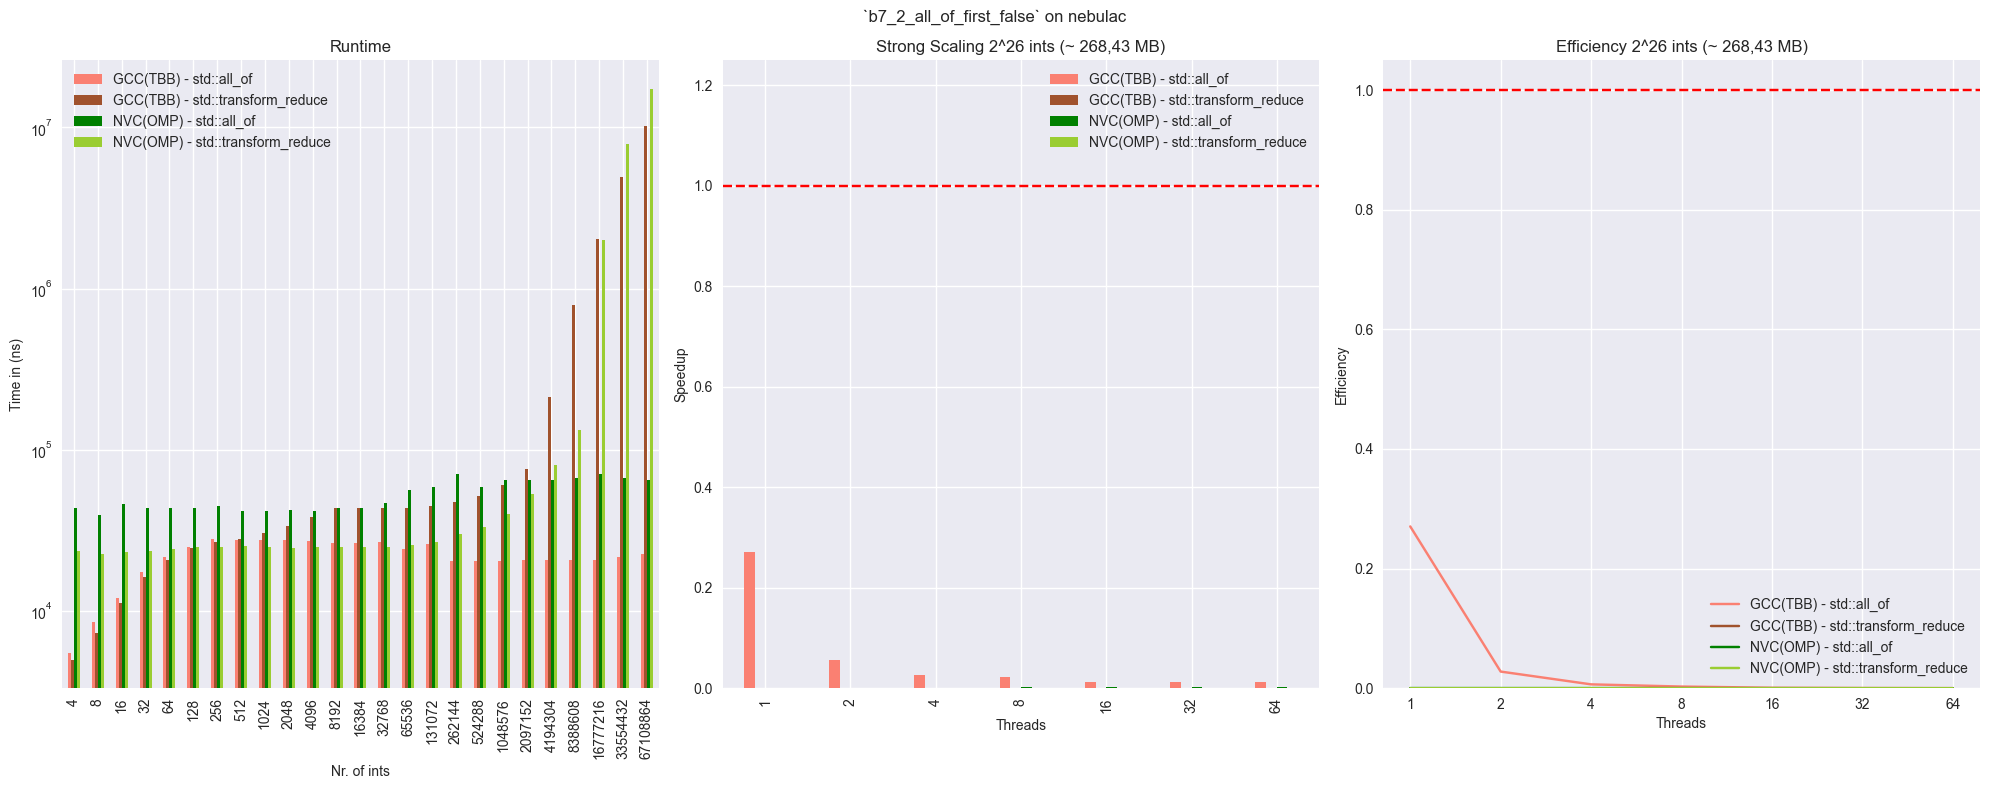

In [329]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(20, 8))


# plot runtime
ax_1 = b7_2_first_false_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY], ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=10)


# plot strong scaling
ax_2 = b7_2_first_false_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY],
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')
ax_2.set_ylim(0,1.25)





# plot efficiency
ax_3 = b7_2_first_false_efficiency.plot(x='threads',
                                                            color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY],
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_ylim(0,1.05)

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')


fig.suptitle(f"`b7_2_all_of_first_false` on {device_name}")

fig.tight_layout()

plot(f"`b7_2_all_of_first_false` {device_name}")

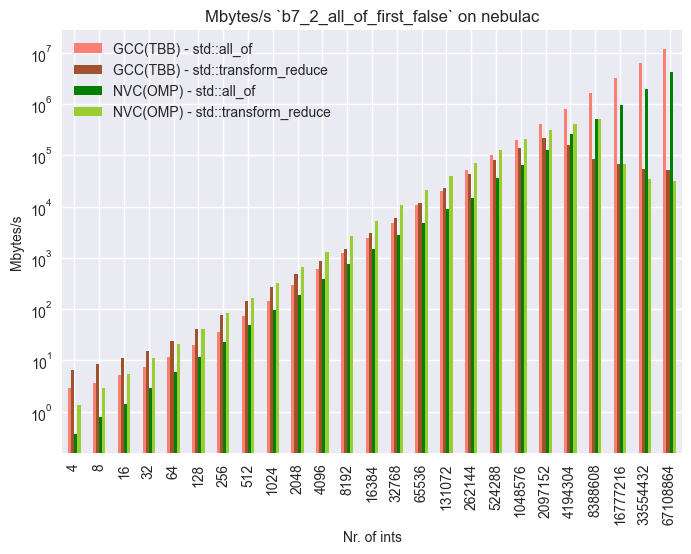

In [330]:

# mybtes graph


b7_2_first_false_bytes_merged.plot(kind='bar',
                       x='n',
                       color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]
                       )

plt.yscale('log',base=10)
plt.ylabel('Mbytes/s')
plt.xlabel('Nr. of ints')
plt.title(f'Mbytes/s `b7_2_all_of_first_false` on {device_name}')


plot(f'`b7_2_all_of_first_false` Mbytes_s on {device_name}')

## `b7_2` -  last_false

In [331]:
benchmark_names = [
    ("b7_2_all_of_last_false",'std::all_of'),
    ("b7_2_custom_all_of_with_transform_reduce_last_false",'std::transform_reduce')
]

strong_scale_base = 'b7_2_all_of_last_false'

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - last_false

Check how the runtime without constraining the threads develops with increasing input size

In [332]:
# collect data for instances
data = [
    par_data_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name 
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]

# merge for plotting
b7_2_last_false_time_merged = data[0]

for i in range(1,len(data)):
    b7_2_last_false_time_merged = pd.merge(b7_2_last_false_time_merged,data[i], on='n')

b7_2_last_false_time_merged

,GCC(TBB) - std::all_of,n,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,5667.29,4,3687.51,49028.2,24539.0
1,13115.50,8,7339.77,40791.8,23973.8
2,18148.60,16,11645.60,40455.5,24839.9
3,23087.70,32,16483.90,41688.5,24195.1
4,26765.00,64,21791.50,42424.9,26566.4
5,29776.20,128,26125.40,43626.3,26740.1
6,30697.30,256,31226.00,43717.6,26096.9
7,31008.40,512,32081.50,43416.0,26816.0
8,32045.70,1024,34449.20,43955.8,27520.2
9,33903.00,2048,37642.00,45572.8,27435.9


### Strong Scaling - last_false
 
2^26 fixed input size with threads 1-64

In [333]:
# collect data for instances
data = [
    get_strong_scaling_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name ,
                  base_of=strong_scale_base
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]


# merge for plotting
b7_2_last_false_strong_scaling_merged = data[0]

for i in range(1,len(data)):
    b7_2_last_false_strong_scaling_merged = pd.merge(b7_2_last_false_strong_scaling_merged,data[i], on='threads')


b7_2_last_false_strong_scaling_merged

,threads,GCC(TBB) - std::all_of,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,1,1.016303,0.707663,0.271135,0.426099
1,2,1.664002,1.383449,0.522353,0.838073
2,4,2.552139,1.733897,1.013885,1.572926
3,8,1.951007,1.954159,0.989867,1.174458
4,16,3.051051,2.119573,1.091709,1.390446
5,32,3.381595,2.210112,1.050634,1.277414
6,64,2.834301,2.166517,0.858990,1.393222


In [334]:
## efficiency graph

b7_2_last_false_efficiency = b7_2_last_false_strong_scaling_merged.copy()

for _,compiler_name in instances:
    for bench_name, display_name in benchmark_names:
        b7_2_last_false_efficiency[f'{compiler_name} - {display_name}'] = b7_2_last_false_efficiency[f'{compiler_name} - {display_name}'] / b7_2_last_false_efficiency['threads']

b7_2_last_false_efficiency

,threads,GCC(TBB) - std::all_of,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,1,1.016303,0.707663,0.271135,0.426099
1,2,0.832001,0.691725,0.261176,0.419036
2,4,0.638035,0.433474,0.253471,0.393231
3,8,0.243876,0.244270,0.123733,0.146807
4,16,0.190691,0.132473,0.068232,0.086903
5,32,0.105675,0.069066,0.032832,0.039919
6,64,0.044286,0.033852,0.013422,0.021769


### Mbytes/s

In [335]:

# collect data for instances
data = [
    bytes_per_second_data_algo(compiler_location=comp_location,
                               compiler_name=f'{comp_name} - {display_name}',
                               benchmark_name=bench_name
                               )
    for comp_location, comp_name in instances
    for bench_name, display_name in benchmark_names
]

# merge for plotting
b7_2_last_false_bytes_merged = data[0]

for i in range(1,len(data)):
    b7_2_last_false_bytes_merged = pd.merge(b7_2_last_false_bytes_merged,data[i], on='n')

b7_2_last_false_bytes_merged

,n,GCC(TBB) - std::all_of,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,4,2.88179,8.62507,0.340020,1.32451
1,8,2.48481,8.61089,0.783453,2.69111
2,16,3.58040,10.80790,1.579350,5.18708
3,32,5.61533,15.28220,3.065950,10.64910
4,64,9.66136,23.17480,6.026730,19.41170
5,128,17.34090,38.87430,11.720400,38.59930
6,256,33.64000,65.17900,23.392800,79.03910
7,512,66.56930,126.71300,47.119600,153.73900
8,1024,128.66400,236.53100,93.156400,298.88900
9,2048,243.09700,433.01400,179.544000,599.40700


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_11879/1369428682.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


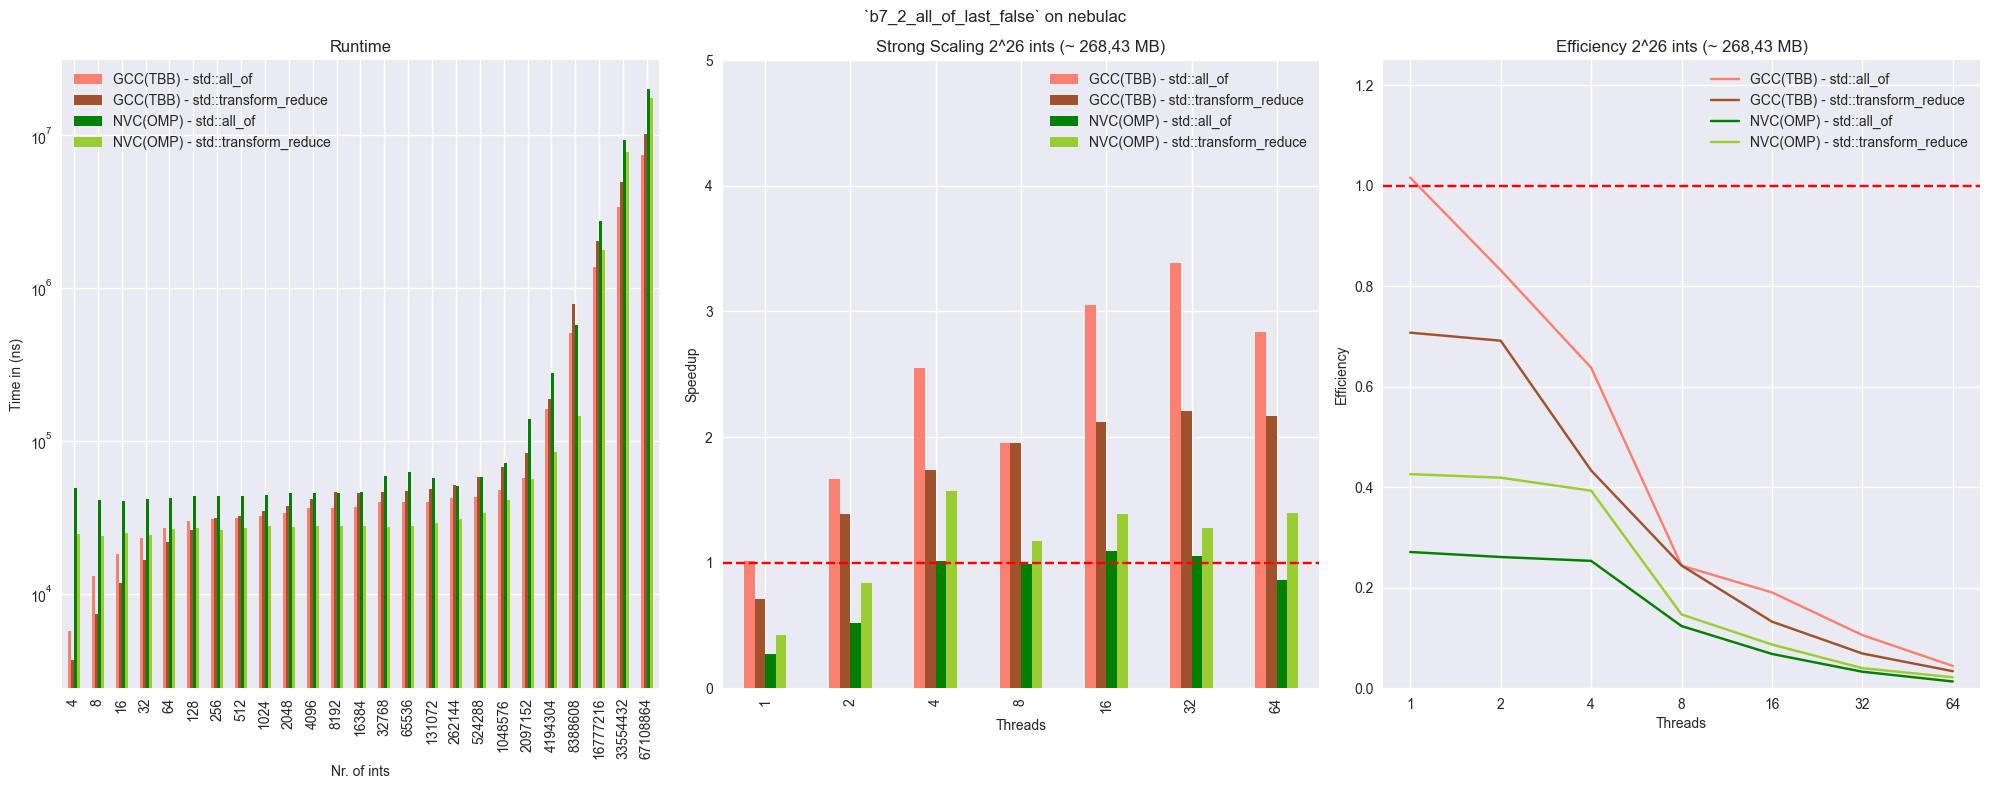

In [336]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(20, 8))


# plot runtime
ax_1 = b7_2_last_false_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY], ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=10)


# plot strong scaling
ax_2 = b7_2_last_false_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY],
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')
ax_2.set_ylim(0,5)





# plot efficiency
ax_3 = b7_2_last_false_efficiency.plot(x='threads',
                                                            color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY],
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_ylim(0,1.25)

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')


fig.suptitle(f"`b7_2_all_of_last_false` on {device_name}")

fig.tight_layout()

plot(f"`b7_2_all_of_last_false` {device_name}")

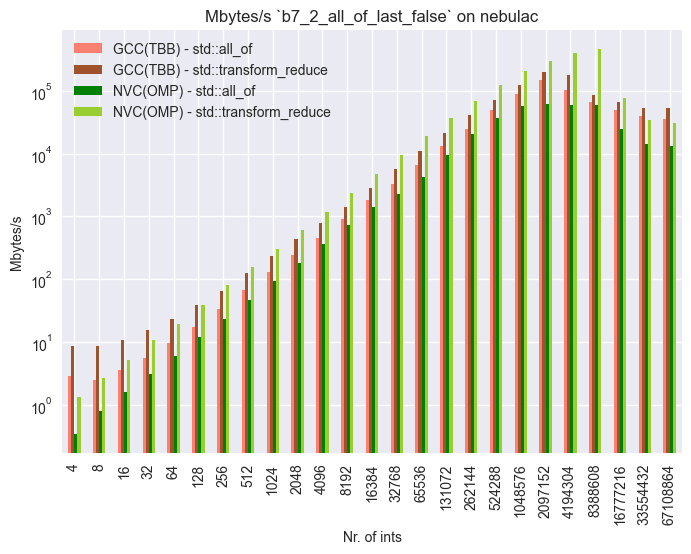

In [337]:
b7_2_last_false_bytes_merged.plot(kind='bar',
                       x='n',
                       color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]
                       )

plt.yscale('log',base=10)
plt.ylabel('Mbytes/s')
plt.xlabel('Nr. of ints')
plt.title(f'Mbytes/s `b7_2_all_of_last_false` on {device_name}')


plot(f'`b7_2_all_of_last_false` Mbytes_s on {device_name}')

## `b7_2` -  auto_false

In [338]:
benchmark_names = [
    ("b7_2_all_of_auto_false",'std::all_of'),
    ("b7_2_custom_all_of_with_transform_reduce_auto_false",'std::transform_reduce')
]

strong_scale_base = 'b7_2_all_of_auto_false'

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - auto_false

Check how the runtime without constraining the threads develops with increasing input size

In [339]:
# collect data for instances
data = [
    par_data_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name 
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]

# merge for plotting
b7_2_auto_false_time_merged = data[0]

for i in range(1,len(data)):
    b7_2_auto_false_time_merged = pd.merge(b7_2_auto_false_time_merged,data[i], on='n')

b7_2_auto_false_time_merged

,GCC(TBB) - std::all_of,n,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,7794.05,4,4616.36,44954.9,23192.1
1,12208.50,8,7218.92,44403.4,21885.7
2,15764.00,16,11346.30,42604.3,22135.5
3,18243.50,32,16511.50,42854.1,23031.1
4,19620.60,64,20900.20,44159.8,24066.5
5,24334.80,128,26311.20,43958.8,26065.7
6,22898.30,256,27618.00,43817.9,25751.2
7,22504.60,512,29230.70,43522.8,23990.6
8,22665.70,1024,31706.30,43959.5,23889.0
9,23274.10,2048,35418.90,45766.2,23579.9


### Strong Scaling - auto_false
 
2^26 fixed input size with threads 1-64

In [340]:
# collect data for instances
data = [
    get_strong_scaling_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name,
                  base_of=strong_scale_base
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]


# merge for plotting
b7_2_auto_false_strong_scaling_merged = data[0]

for i in range(1,len(data)):
    b7_2_auto_false_strong_scaling_merged = pd.merge(b7_2_auto_false_strong_scaling_merged,data[i], on='threads')


b7_2_auto_false_strong_scaling_merged

,threads,GCC(TBB) - std::all_of,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,1,0.274658,0.000044,0.001003,0.250015
1,2,0.072822,0.000089,0.001866,0.050079
2,4,0.034603,0.000175,0.003107,0.023422
3,8,0.016081,0.000327,0.003807,0.016146
4,16,0.012258,0.000591,0.004404,0.011730
5,32,0.013714,0.000916,0.004470,0.010768
6,64,0.012623,0.001394,0.004777,0.010033


In [341]:
## efficiency graph

b7_2_auto_false_efficiency = b7_2_auto_false_strong_scaling_merged.copy()

for _,compiler_name in instances:
    for bench_name, display_name in benchmark_names:
        b7_2_auto_false_efficiency[f'{compiler_name} - {display_name}'] = b7_2_auto_false_efficiency[f'{compiler_name} - {display_name}'] / b7_2_auto_false_efficiency['threads']

b7_2_auto_false_efficiency

,threads,GCC(TBB) - std::all_of,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,1,0.274658,0.000044,0.001003,0.250015
1,2,0.036411,0.000044,0.000933,0.025039
2,4,0.008651,0.000044,0.000777,0.005856
3,8,0.002010,0.000041,0.000476,0.002018
4,16,0.000766,0.000037,0.000275,0.000733
5,32,0.000429,0.000029,0.000140,0.000336
6,64,0.000197,0.000022,0.000075,0.000157


### Mbytes/s

In [342]:
# collect data for instances
data = [
    bytes_per_second_data_algo(compiler_location=comp_location,
                               compiler_name=f'{comp_name} - {display_name}',
                               benchmark_name=bench_name
                               )
    for comp_location, comp_name in instances
    for bench_name, display_name in benchmark_names
]

# merge for plotting
b7_2_auto_false_bytes_merged = data[0]

for i in range(1,len(data)):
    b7_2_auto_false_bytes_merged = pd.merge(b7_2_auto_false_bytes_merged,data[i], on='n')

b7_2_auto_false_bytes_merged

,n,GCC(TBB) - std::all_of,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,4,2.057300e+00,7.103190e+00,3.569260e-01,1.419110e+00
1,8,2.592450e+00,8.975250e+00,7.160720e-01,2.952120e+00
2,16,4.017160e+00,1.146400e+01,1.488660e+00,5.815240e+00
3,32,7.011910e+00,1.574800e+01,2.960810e+00,1.111490e+01
4,64,1.300010e+01,2.482910e+01,5.760330e+00,2.136290e+01
5,128,2.104530e+01,3.955160e+01,1.157030e+01,3.977560e+01
6,256,4.454120e+01,7.485930e+01,2.321450e+01,8.030990e+01
7,512,9.034610e+01,1.413120e+02,4.673360e+01,1.715240e+02
8,1024,1.796400e+02,2.602410e+02,9.256640e+01,3.444990e+02
9,2048,3.511660e+02,4.653310e+02,1.788520e+02,6.985820e+02


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_11879/1629545763.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


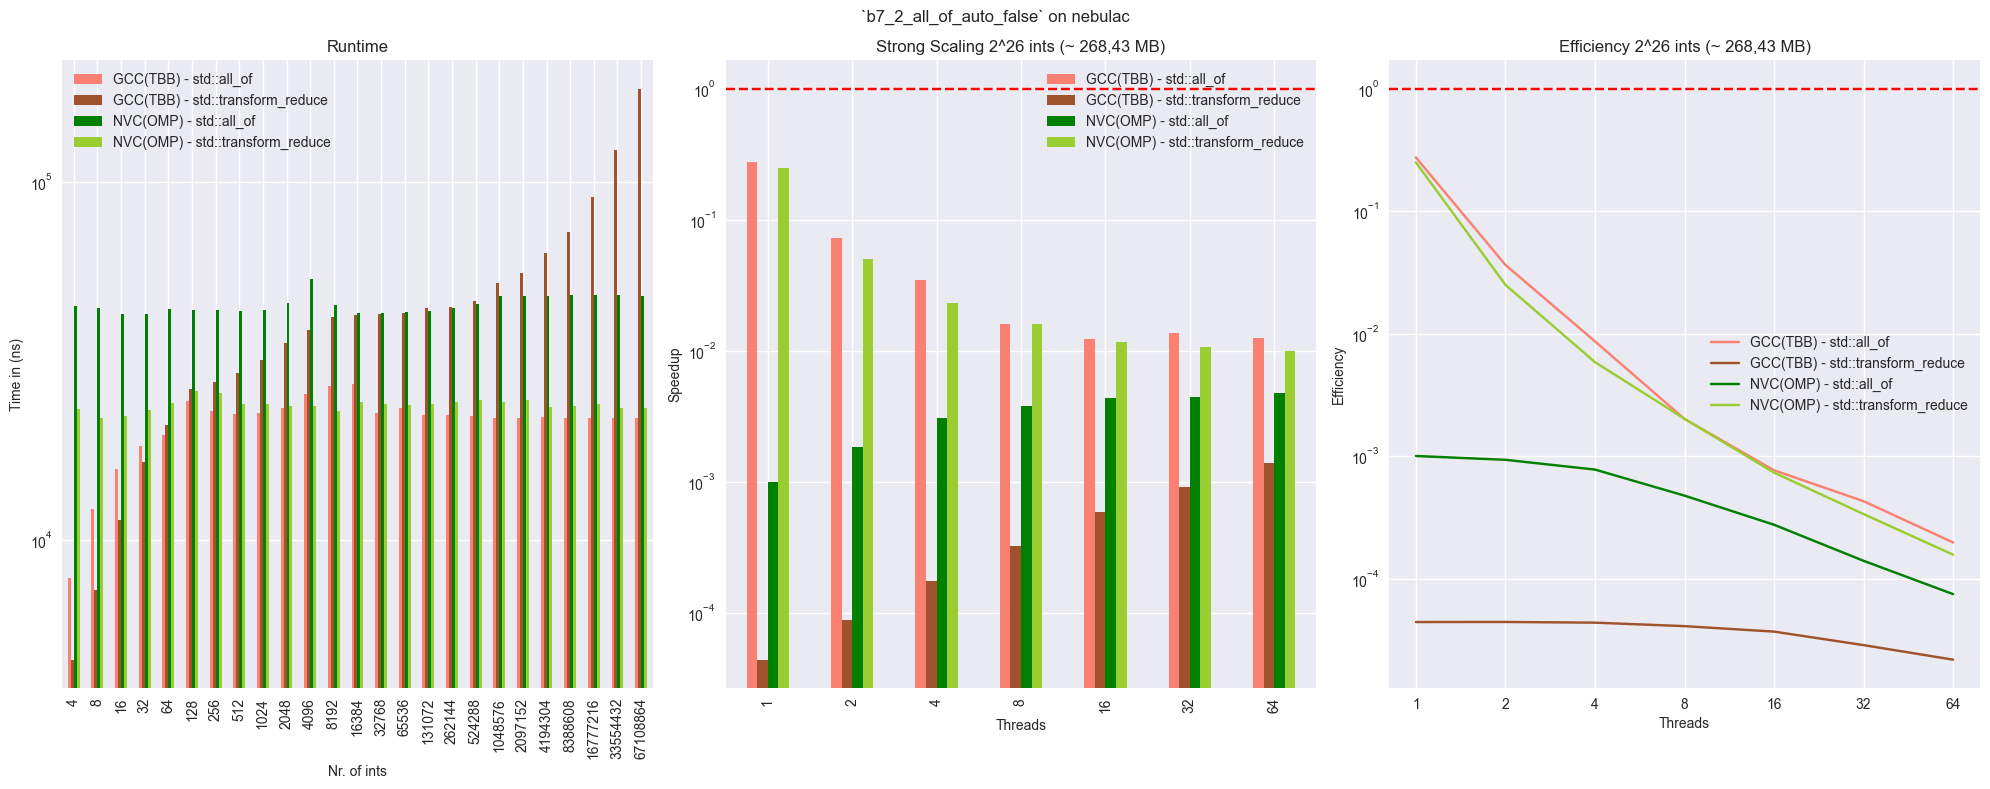

In [343]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(20, 8))


# plot runtime
ax_1 = b7_2_auto_false_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY], ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=10)


# plot strong scaling
ax_2 = b7_2_auto_false_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY],
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

ax_2.set_yscale('log',base=10)
ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')



# plot efficiency
ax_3 = b7_2_auto_false_efficiency.plot(x='threads',
                                                            color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY],
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_yscale('log',base=10)

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')


fig.suptitle(f"`b7_2_all_of_auto_false` on {device_name}")

fig.tight_layout()

plot(f"`b7_2_all_of_auto_false` {device_name}")

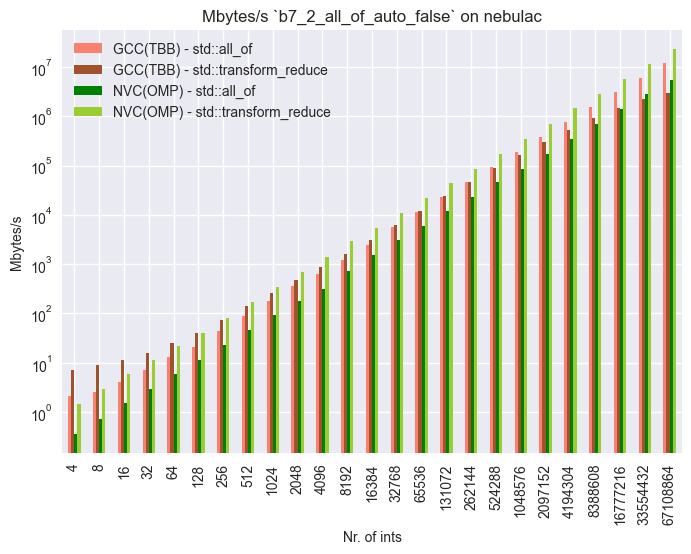

In [344]:

# mybtes graph

b7_2_auto_false_bytes_merged.plot(kind='bar',
                       x='n',
                       color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]
                       )

plt.yscale('log',base=10)
plt.ylabel('Mbytes/s')
plt.xlabel('Nr. of ints')
plt.title(f'Mbytes/s `b7_2_all_of_auto_false` on {device_name}')


plot(f'`b7_2_all_of_auto_false` Mbytes_s on {device_name}')

## `b7_3` -  all_hit

In [345]:
benchmark_names = [
    ("b7_3_count_if_all_hit",'std::count_if'),
    ("b7_3_custom_count_if_with_transform_reduce_all_hit",'std::transform_reduce'),
    #("b7_3_custom_count_if_with_for_each_all_hit",'std::for_each')
]

strong_scale_base = 'b7_3_count_if_all_hit'

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - all_hit

Check how the runtime without constraining the threads develops with increasing input size

In [346]:
# collect data for instances
data = [
    par_data_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name 
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]

# merge for plotting
b7_3_all_hit_time_merged = data[0]

for i in range(1,len(data)):
    b7_3_all_hit_time_merged = pd.merge(b7_3_all_hit_time_merged,data[i], on='n')

b7_3_all_hit_time_merged

,GCC(TBB) - std::count_if,n,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::count_if,NVC(OMP) - std::transform_reduce
0,8464.46,4,6259.00,28165.6,22736.8
1,16576.90,8,9235.84,21407.0,21651.7
2,22898.60,16,14612.30,21461.5,23223.5
3,27632.40,32,20304.90,22002.7,28709.3
4,31091.50,64,24869.50,22775.2,22280.2
5,33052.90,128,28414.70,22474.4,22272.7
6,33577.50,256,31084.30,22748.5,22855.7
7,35181.90,512,32179.80,22941.6,23287.7
8,37719.80,1024,33722.70,22623.4,23290.7
9,41171.80,2048,36132.40,22611.9,23126.9


### Strong Scaling - all_hit
 
2^26 fixed input size with threads 1-64

In [347]:
# collect data for instances
data = [
    get_strong_scaling_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name ,
                  base_of=strong_scale_base
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]


# merge for plotting
b7_3_all_hit_strong_scaling_merged = data[0]

for i in range(1,len(data)):
    b7_3_all_hit_strong_scaling_merged = pd.merge(b7_3_all_hit_strong_scaling_merged,data[i], on='threads')


b7_3_all_hit_strong_scaling_merged

,threads,GCC(TBB) - std::count_if,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::count_if,NVC(OMP) - std::transform_reduce
0,1,1.052365,0.634358,1.029449,1.527985
1,2,1.743168,1.247992,1.789703,2.435724
2,4,2.244143,2.105385,1.597762,2.319168
3,8,1.659173,1.574182,1.069543,1.356167
4,16,2.054889,1.886827,1.328322,1.270540
5,32,2.054343,2.062566,1.201466,1.227231
6,64,1.926974,1.850458,1.224156,1.205643


In [348]:
## efficiency graph

b7_3_all_hit_efficiency = b7_3_all_hit_strong_scaling_merged.copy()

for _,compiler_name in instances:
    for bench_name, display_name in benchmark_names:
        b7_3_all_hit_efficiency[f'{compiler_name} - {display_name}'] = b7_3_all_hit_efficiency[f'{compiler_name} - {display_name}'] / b7_3_all_hit_efficiency['threads']

b7_3_all_hit_efficiency

,threads,GCC(TBB) - std::count_if,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::count_if,NVC(OMP) - std::transform_reduce
0,1,1.052365,0.634358,1.029449,1.527985
1,2,0.871584,0.623996,0.894852,1.217862
2,4,0.561036,0.526346,0.399441,0.579792
3,8,0.207397,0.196773,0.133693,0.169521
4,16,0.128431,0.117927,0.083020,0.079409
5,32,0.064198,0.064455,0.037546,0.038351
6,64,0.030109,0.028913,0.019127,0.018838


### Mbytes/s

In [349]:

# collect data for instances
data = [
    bytes_per_second_data_algo(compiler_location=comp_location,
                               compiler_name=f'{comp_name} - {display_name}',
                               benchmark_name=bench_name
                               )
    for comp_location, comp_name in instances
    for bench_name, display_name in benchmark_names
]

# merge for plotting
b7_3_all_hit_bytes_merged = data[0]

for i in range(1,len(data)):
    b7_3_all_hit_bytes_merged = pd.merge(b7_3_all_hit_bytes_merged,data[i], on='n')

b7_3_all_hit_bytes_merged

,n,GCC(TBB) - std::count_if,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::count_if,NVC(OMP) - std::transform_reduce
0,4,1.95157,2.60036,0.643765,0.714599
1,8,1.95001,3.49348,1.503390,1.485430
2,16,2.82043,4.42311,2.995940,2.794310
3,32,4.66553,6.36553,5.847470,4.494620
4,64,8.27891,10.38260,11.285000,11.578800
5,128,15.55180,18.15410,22.875900,23.180100
6,256,30.55940,33.17640,45.191300,45.160300
7,512,58.21570,64.10700,89.646500,88.569000
8,1024,108.46900,122.44500,181.838000,177.150000
9,2048,198.64100,228.37600,363.660000,357.129000


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_11879/3164471847.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


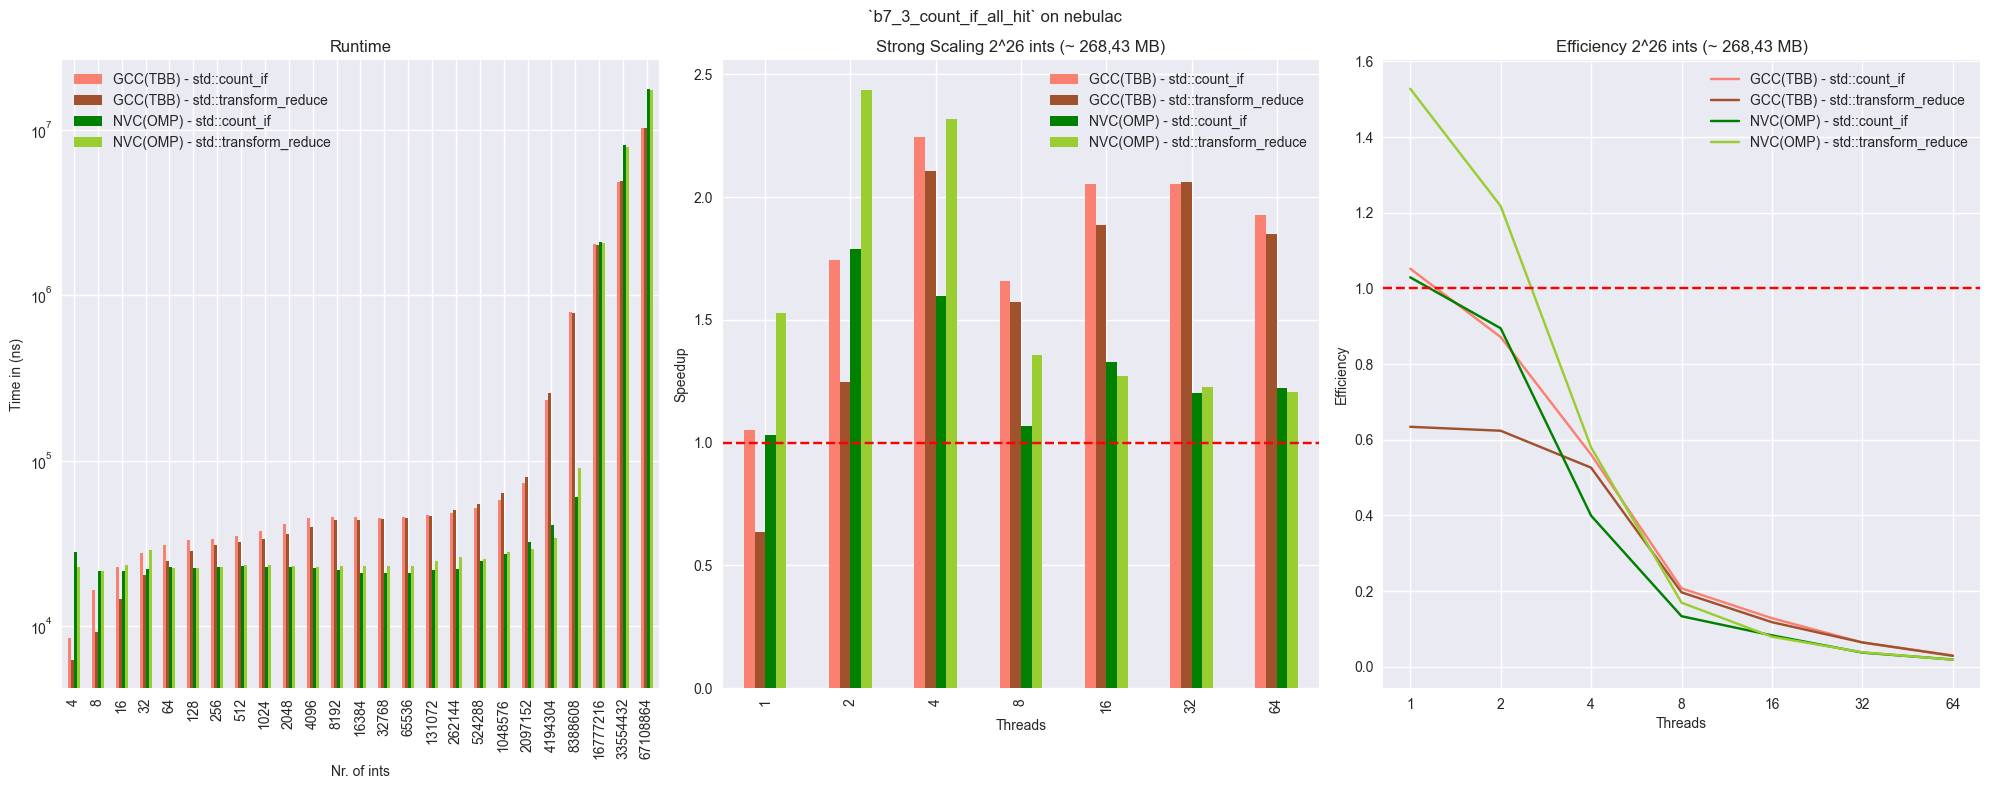

In [350]:
# graphs 

colorArray =[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(20, 8))


# plot runtime
ax_1 = b7_3_all_hit_time_merged.plot(kind='bar',x='n',align='center',color=colorArray, ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=10)


# plot strong scaling
ax_2 = b7_3_all_hit_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=colorArray,
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')





# plot efficiency
ax_3 = b7_3_all_hit_efficiency.plot(x='threads',
                                                            color=colorArray,
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')

fig.suptitle(f"`b7_3_count_if_all_hit` on {device_name}")

fig.tight_layout()

plot(f"`b7_3_count_if_all_hit` {device_name}")

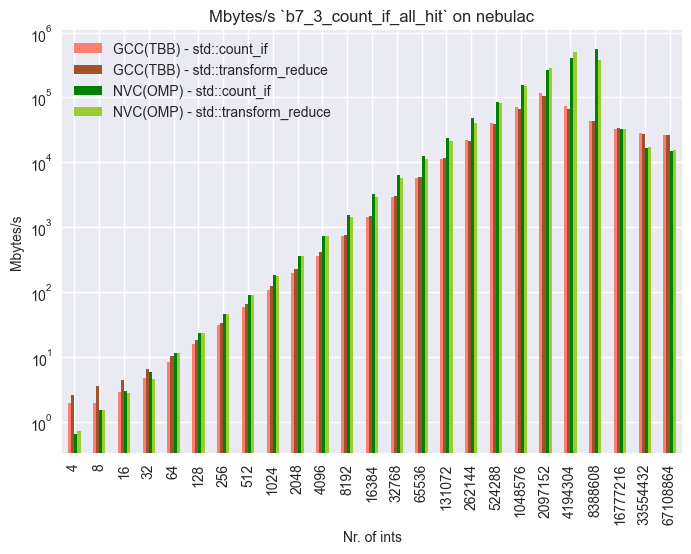

In [351]:
# mybtes graph

b7_3_all_hit_bytes_merged.plot(kind='bar',
                       x='n',
                       color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]
                       )

plt.yscale('log',base=10)
plt.ylabel('Mbytes/s')
plt.xlabel('Nr. of ints')
plt.title(f'Mbytes/s `b7_3_count_if_all_hit` on {device_name}')


plot(f'`b7_3_count_if_all_hit` Mbytes_s on {device_name}')

## `b7_3` -  half_hit

In [352]:
benchmark_names = [
    ("b7_3_count_if_half_hit",'std::count_if'),
    ("b7_3_custom_count_if_with_transform_reduce_half_hit",'std::transform_reduce'),
    #("b7_3_custom_count_if_with_for_each_half_hit",'std::for_each')
]

strong_scale_base = 'b7_3_count_if_half_hit'

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - half_hit

Check how the runtime without constraining the threads develops with increasing input size

In [353]:
# collect data for instances
data = [
    par_data_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name 
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]

# merge for plotting
b7_3_half_hit_time_merged = data[0]

for i in range(1,len(data)):
    b7_3_half_hit_time_merged = pd.merge(b7_3_half_hit_time_merged,data[i], on='n')

b7_3_half_hit_time_merged

,GCC(TBB) - std::count_if,n,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::count_if,NVC(OMP) - std::transform_reduce
0,7981.53,4,3803.76,23119.6,23501.0
1,12669.60,8,9391.36,21261.7,19310.5
2,19782.70,16,14928.10,21514.3,20719.9
3,22902.90,32,20937.80,22551.0,23022.9
4,26429.00,64,25548.40,22031.1,23854.7
5,28305.50,128,28756.50,22508.7,23909.3
6,30120.30,256,30222.30,22390.5,23044.5
7,33503.60,512,29859.80,22366.1,23075.3
8,36579.10,1024,31689.90,22191.4,23414.8
9,40390.50,2048,35065.40,22378.4,23515.4


### Strong Scaling - half_hit
 
2^26 fixed input size with threads 1-64

In [354]:
# collect data for instances
data = [
    get_strong_scaling_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name ,
                  base_of=strong_scale_base
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]


# merge for plotting
b7_3_half_hit_strong_scaling_merged = data[0]

for i in range(1,len(data)):
    b7_3_half_hit_strong_scaling_merged = pd.merge(b7_3_half_hit_strong_scaling_merged,data[i], on='threads')


b7_3_half_hit_strong_scaling_merged

,threads,GCC(TBB) - std::count_if,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::count_if,NVC(OMP) - std::transform_reduce
0,1,1.050270,0.627331,0.985467,1.468114
1,2,1.920180,1.267253,1.366651,1.784074
2,4,2.516277,1.382250,1.783123,2.183329
3,8,1.442758,2.220618,1.122101,1.412144
4,16,1.940664,1.926725,1.403904,1.224913
5,32,2.141660,2.122849,1.334493,1.269104
6,64,1.968325,1.871903,1.319374,1.167830


In [355]:
## efficiency graph

b7_3_half_hit_efficiency = b7_3_half_hit_strong_scaling_merged.copy()

for _,compiler_name in instances:
    for bench_name, display_name in benchmark_names:
        b7_3_half_hit_efficiency[f'{compiler_name} - {display_name}'] = b7_3_half_hit_efficiency[f'{compiler_name} - {display_name}'] / b7_3_half_hit_efficiency['threads']

b7_3_half_hit_efficiency

,threads,GCC(TBB) - std::count_if,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::count_if,NVC(OMP) - std::transform_reduce
0,1,1.050270,0.627331,0.985467,1.468114
1,2,0.960090,0.633626,0.683325,0.892037
2,4,0.629069,0.345563,0.445781,0.545832
3,8,0.180345,0.277577,0.140263,0.176518
4,16,0.121291,0.120420,0.087744,0.076557
5,32,0.066927,0.066339,0.041703,0.039660
6,64,0.030755,0.029248,0.020615,0.018247


### Mybtes/s

In [356]:

# collect data for instances
data = [
    bytes_per_second_data_algo(compiler_location=comp_location,
                               compiler_name=f'{comp_name} - {display_name}',
                               benchmark_name=bench_name
                               )
    for comp_location, comp_name in instances
    for bench_name, display_name in benchmark_names
]

# merge for plotting
b7_3_half_hit_bytes_merged = data[0]

for i in range(1,len(data)):
    b7_3_half_hit_bytes_merged = pd.merge(b7_3_half_hit_bytes_merged,data[i], on='n')

b7_3_half_hit_bytes_merged


,n,GCC(TBB) - std::count_if,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::count_if,NVC(OMP) - std::transform_reduce
0,4,2.04433,4.30835,0.719343,0.722581
1,8,2.55838,3.45095,1.525700,1.668620
2,16,3.30213,4.35162,3.015270,3.104160
3,32,5.63370,6.19849,5.747910,5.579940
4,64,9.73150,10.14130,11.769900,10.764900
5,128,18.12260,18.00100,23.034800,21.491700
6,256,33.98940,34.25850,46.333300,44.579300
7,512,61.11320,69.12250,92.767000,89.045000
8,1024,111.88600,130.11300,187.023000,175.657000
9,2048,202.64000,235.31100,371.296000,349.812000


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_11879/4180608575.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


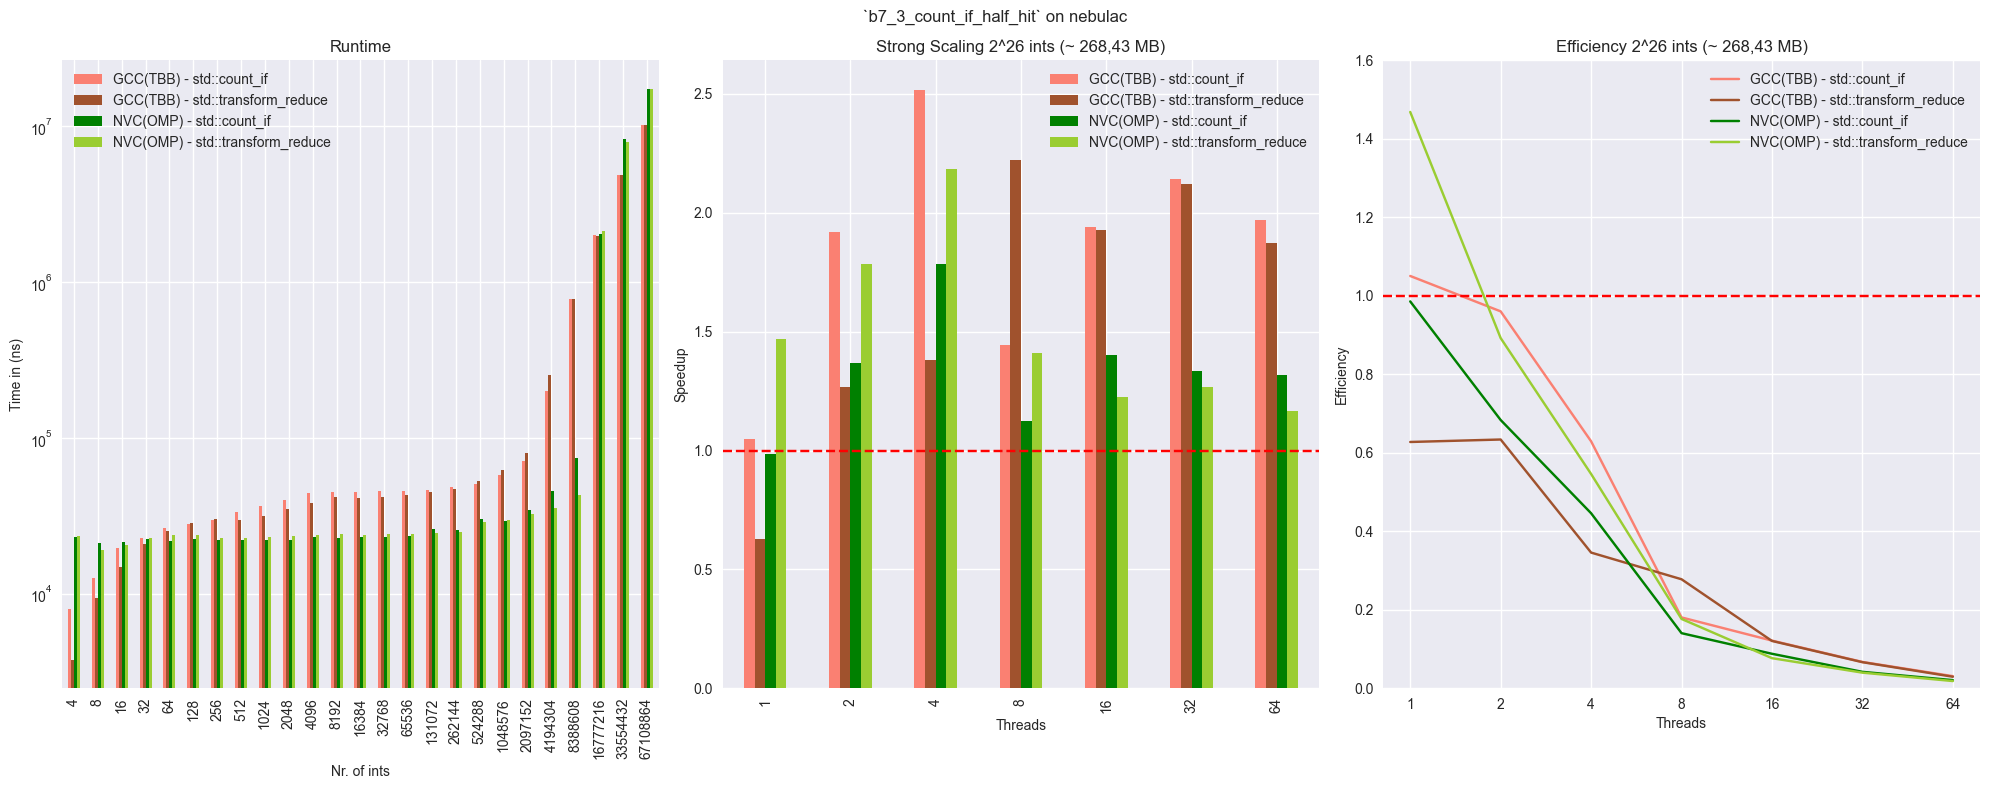

In [357]:
# graphs 

colorArray =[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(20, 8))


# plot runtime
ax_1 = b7_3_half_hit_time_merged.plot(kind='bar',x='n',align='center',color=colorArray, ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=10)


# plot strong scaling
ax_2 = b7_3_half_hit_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=colorArray,
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')





# plot efficiency
ax_3 = b7_3_half_hit_efficiency.plot(x='threads',
                                                            color=colorArray,
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')
ax_3.set_ylim(0,1.6)


fig.suptitle(f"`b7_3_count_if_half_hit` on {device_name}")

fig.tight_layout()

plot(f"`b7_3_count_if_half_hit` {device_name}")

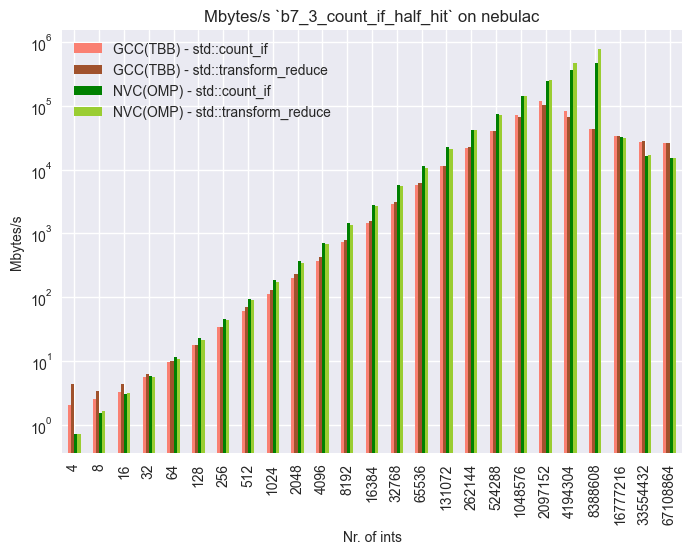

In [358]:
# mybtes graph

b7_3_half_hit_bytes_merged.plot(kind='bar',
                       x='n',
                       color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]
                       )

plt.yscale('log',base=10)
plt.ylabel('Mbytes/s')
plt.xlabel('Nr. of ints')
plt.title(f'Mbytes/s `b7_3_count_if_half_hit` on {device_name}')


plot(f'`b7_3_count_if_half_hit` Mbytes_s on {device_name}')

## `b7_3` -  orders_struct

In [359]:
benchmark_names = [
    ("b7_3_count_if_orders_struct",'std::count_if'),
    ("b7_3_custom_count_if_with_transform_reduce_orders_struct",'std::transform_reduce'),
    #("b7_3_custom_count_if_with_for_each_orders_struct",'std::for_each')
]

strong_scale_base = 'b7_3_count_if_orders_struct'

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - orders_struct

Check how the runtime without constraining the threads develops with increasing input size

In [360]:
# collect data for instances
data = [
    par_data_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name 
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]

# merge for plotting
b7_3_orders_struct_time_merged = data[0]

for i in range(1,len(data)):
    b7_3_orders_struct_time_merged = pd.merge(b7_3_orders_struct_time_merged,data[i], on='n')

b7_3_orders_struct_time_merged

,GCC(TBB) - std::count_if,n,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::count_if,NVC(OMP) - std::transform_reduce
0,6380.7,4,5947.38,22122.4,29052.4
1,11448.4,8,8682.98,21647.7,21563.9
2,17735.2,16,13034.50,19646.8,21373.5
3,22695.9,32,17825.20,20998.5,23610.4
4,26696.3,64,21976.10,21350.6,23894.8
5,28988.2,128,25020.10,24416.4,23836.8
6,31968.6,256,26944.50,23055.3,24655.4
7,35271.9,512,28348.60,20813.5,24889.6
8,38837.0,1024,31067.40,20769.8,25531.6
9,43313.9,2048,34745.00,20541.0,24506.0


### Strong Scaling - orders_struct
 
2^26 fixed input size with threads 1-64

In [361]:
# collect data for instances
data = [
    get_strong_scaling_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name,
                  base_of=strong_scale_base 
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]


# merge for plotting
b7_3_orders_struct_strong_scaling_merged = data[0]

for i in range(1,len(data)):
    b7_3_orders_struct_strong_scaling_merged = pd.merge(b7_3_orders_struct_strong_scaling_merged,data[i], on='threads')


b7_3_orders_struct_strong_scaling_merged

,threads,GCC(TBB) - std::count_if,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::count_if,NVC(OMP) - std::transform_reduce
0,1,0.998395,0.782729,1.166956,1.182925
1,2,1.852029,1.502558,1.693008,1.359820
2,4,2.398694,2.412190,2.161475,2.067858
3,8,1.975321,1.664115,1.995568,1.579224
4,16,1.957561,1.879635,1.285037,1.228354
5,32,2.091696,2.138683,1.311163,1.313377
6,64,1.870362,1.882287,1.230248,1.217422


In [362]:
## efficiency graph

b7_3_orders_struct_efficiency = b7_3_orders_struct_strong_scaling_merged.copy()

for _,compiler_name in instances:
    for bench_name, display_name in benchmark_names:
        b7_3_orders_struct_efficiency[f'{compiler_name} - {display_name}'] = b7_3_orders_struct_efficiency[f'{compiler_name} - {display_name}'] / b7_3_orders_struct_efficiency['threads']

b7_3_orders_struct_efficiency

,threads,GCC(TBB) - std::count_if,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::count_if,NVC(OMP) - std::transform_reduce
0,1,0.998395,0.782729,1.166956,1.182925
1,2,0.926014,0.751279,0.846504,0.679910
2,4,0.599674,0.603048,0.540369,0.516965
3,8,0.246915,0.208014,0.249446,0.197403
4,16,0.122348,0.117477,0.080315,0.076772
5,32,0.065365,0.066834,0.040974,0.041043
6,64,0.029224,0.029411,0.019223,0.019022


### Mbytes/s

In [363]:

# collect data for instances
data = [
    bytes_per_second_data_algo(compiler_location=comp_location,
                               compiler_name=f'{comp_name} - {display_name}',
                               benchmark_name=bench_name
                               )
    for comp_location, comp_name in instances
    for bench_name, display_name in benchmark_names
]

# merge for plotting
b7_3_orders_struct_bytes_merged = data[0]

for i in range(1,len(data)):
    b7_3_orders_struct_bytes_merged = pd.merge(b7_3_orders_struct_bytes_merged,data[i], on='n')

b7_3_orders_struct_bytes_merged

,n,GCC(TBB) - std::count_if,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::count_if,NVC(OMP) - std::transform_reduce
0,4,4.94603,5.61071,1.46272,1.23843
1,8,5.52428,7.45619,2.96401,2.96489
2,16,7.13276,10.01150,6.51093,5.96473
3,32,11.17510,14.63330,12.18940,10.82990
4,64,19.04830,23.66270,23.98060,21.40240
5,128,35.14260,41.45730,42.37170,42.92070
6,256,63.78730,76.83830,89.96680,82.94020
7,512,115.68400,145.88900,196.74700,164.29200
8,1024,210.27400,265.94400,394.31900,321.10600
9,2048,377.30900,475.03900,797.39200,668.43900


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_11879/2492568009.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


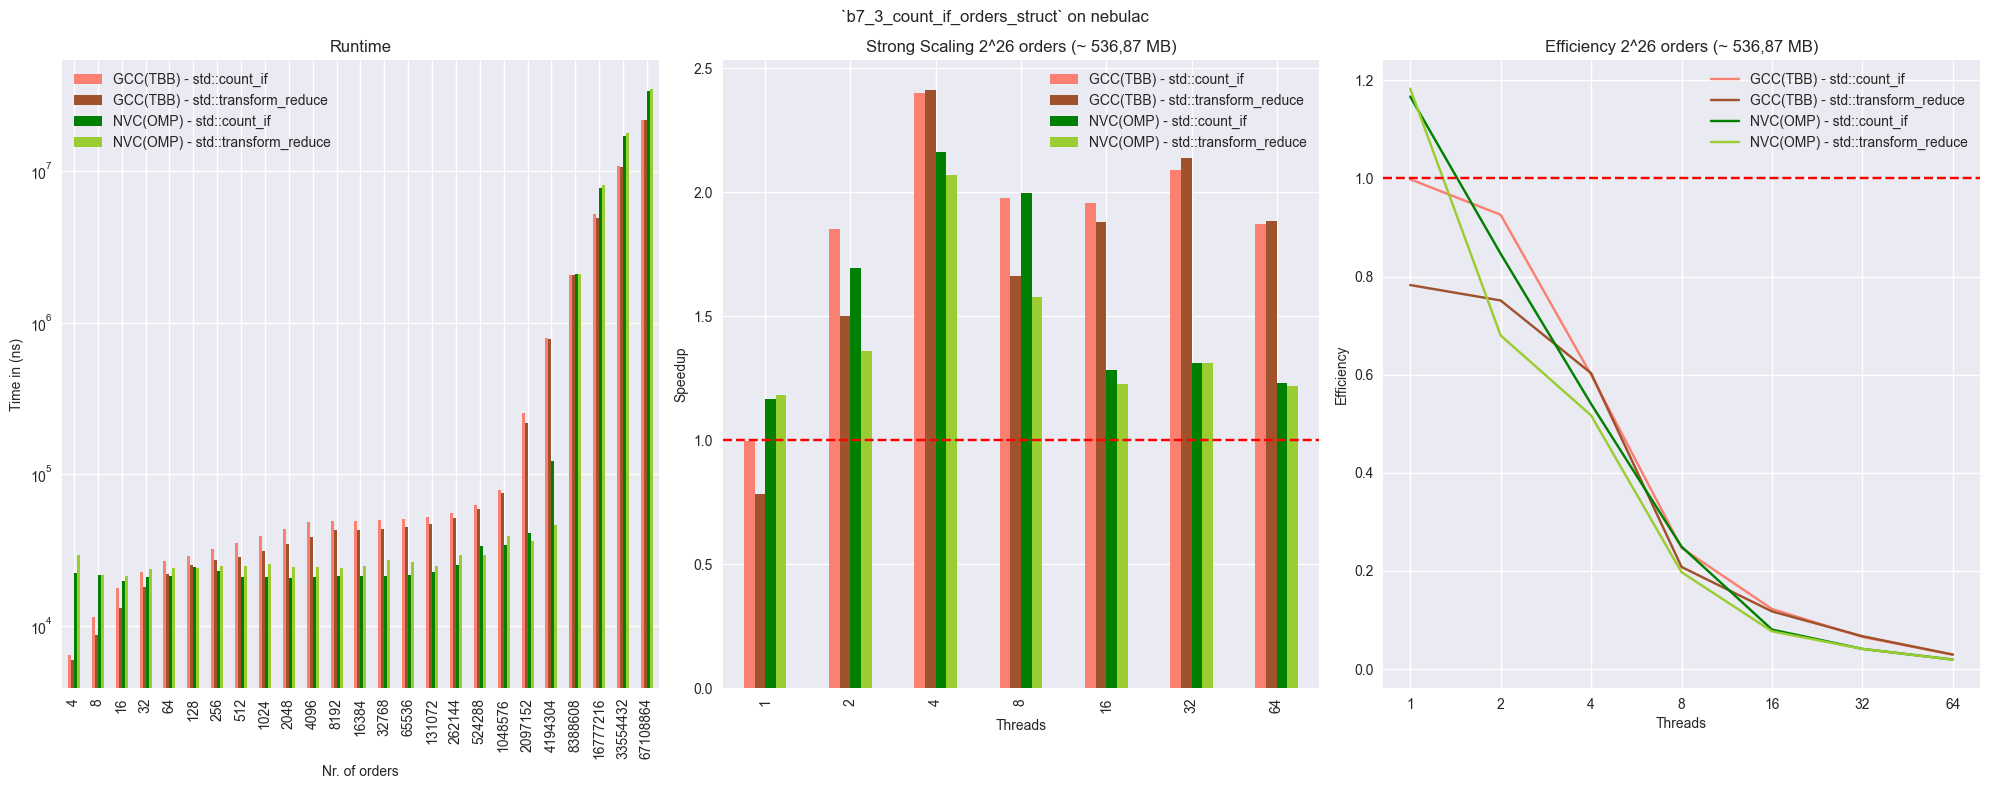

In [364]:
# graphs 

colorArray =[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(20, 8))


# plot runtime
ax_1 = b7_3_orders_struct_time_merged.plot(kind='bar',x='n',align='center',color=colorArray, ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of orders')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=10)


# plot strong scaling
ax_2 = b7_3_orders_struct_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=colorArray,
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 orders (~ 536,87 MB)')





# plot efficiency
ax_3 = b7_3_orders_struct_efficiency.plot(x='threads',
                                                            color=colorArray,
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 orders (~ 536,87 MB)')


fig.suptitle(f"`b7_3_count_if_orders_struct` on {device_name}")

fig.tight_layout()

plot(f"`b7_3_count_if_orders_struct` {device_name}")

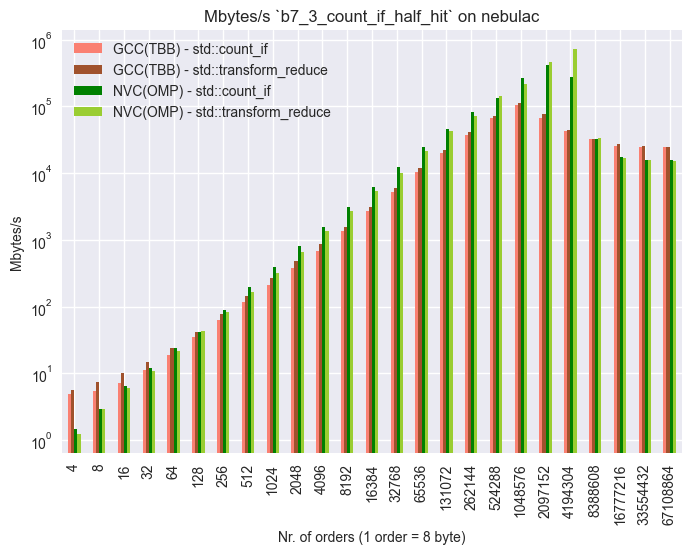

In [365]:
# mybtes graph

b7_3_orders_struct_bytes_merged.plot(kind='bar',
                       x='n',
                       color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]
                       )

plt.yscale('log',base=10)
plt.ylabel('Mbytes/s')
plt.xlabel('Nr. of orders (1 order = 8 byte)')
plt.title(f'Mbytes/s `b7_3_count_if_half_hit` on {device_name}')


plot(f'`b7_3_count_if_orders_struct` Mbytes_s on {device_name}')

## `b7_4` - stencil transform 

In [366]:
benchmark_names = [
    ("b7_4_stencil_transform_number_to_neightbours_stdev",'std::transform'),
    ("b7_4_stencil_for_each_to_neightbours_stdev",'std::for_each')
]

strong_scale_base = 'b7_4_stencil_transform_number_to_neightbours_stdev'

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison -

Check how the runtime without constraining the threads develops with increasing input size

In [367]:
# collect data for instances
data = [
    par_data_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name 
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]

# merge for plotting
b7_4_stencil_time_merged = data[0]

for i in range(1,len(data)):
    b7_4_stencil_time_merged = pd.merge(b7_4_stencil_time_merged,data[i], on='n')

b7_4_stencil_time_merged

,GCC(TBB) - std::transform,n,GCC(TBB) - std::for_each,NVC(OMP) - std::transform,NVC(OMP) - std::for_each
0,3746.72,4,3926.7,12061.9,11336.0
1,8684.33,8,9477.7,11838.3,10731.2
2,15082.30,16,19988.3,11457.1,11252.9
3,20254.60,32,25046.7,11585.9,11991.7
4,24260.10,64,28411.7,12925.4,12698.9
5,25900.40,128,29642.4,12457.3,13103.1
6,28454.40,256,30939.4,12061.2,13420.0
7,32678.90,512,34161.3,12338.3,13373.7
8,36264.90,1024,37495.1,11578.3,11657.7
9,41339.70,2048,42097.4,12105.8,12153.5


### Strong Scaling -
 
2^26 fixed input size with threads 1-64

In [368]:
# collect data for instances
data = [
    get_strong_scaling_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name,
                  base_of=strong_scale_base
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]


# merge for plotting
b7_4_stencil_strong_scaling_merged = data[0]

for i in range(1,len(data)):
    b7_4_stencil_strong_scaling_merged = pd.merge(b7_4_stencil_strong_scaling_merged,data[i], on='threads')


b7_4_stencil_strong_scaling_merged

,threads,GCC(TBB) - std::transform,GCC(TBB) - std::for_each,NVC(OMP) - std::transform,NVC(OMP) - std::for_each
0,1,0.208353,0.201138,0.319116,0.163312
1,2,0.416712,0.401570,0.637921,0.325158
2,4,0.821269,0.790269,1.229097,0.655157
3,8,0.856017,0.984887,1.364756,1.012270
4,16,0.918364,0.912064,1.346166,0.998319
5,32,0.948774,0.981245,1.258635,0.999608
6,64,0.911792,0.911568,1.133158,0.903124


In [369]:
## efficiency graph

b7_4_stencil_efficiency = b7_4_stencil_strong_scaling_merged.copy()

for _,compiler_name in instances:
    for bench_name, display_name in benchmark_names:
        b7_4_stencil_efficiency[f'{compiler_name} - {display_name}'] = b7_4_stencil_efficiency[f'{compiler_name} - {display_name}'] / b7_4_stencil_efficiency['threads']

b7_4_stencil_efficiency

,threads,GCC(TBB) - std::transform,GCC(TBB) - std::for_each,NVC(OMP) - std::transform,NVC(OMP) - std::for_each
0,1,0.208353,0.201138,0.319116,0.163312
1,2,0.208356,0.200785,0.318960,0.162579
2,4,0.205317,0.197567,0.307274,0.163789
3,8,0.107002,0.123111,0.170594,0.126534
4,16,0.057398,0.057004,0.084135,0.062395
5,32,0.029649,0.030664,0.039332,0.031238
6,64,0.014247,0.014243,0.017706,0.014111


### Mbytes/s

In [370]:

# collect data for instances
data = [
    bytes_per_second_data_algo(compiler_location=comp_location,
                               compiler_name=f'{comp_name} - {display_name}',
                               benchmark_name=bench_name
                               )
    for comp_location, comp_name in instances
    for bench_name, display_name in benchmark_names
]

# merge for plotting
b7_4_stencil_bytes_merged = data[0]

for i in range(1,len(data)):
    b7_4_stencil_bytes_merged = pd.merge(b7_4_stencil_bytes_merged,data[i], on='n')

b7_4_stencil_bytes_merged


,n,GCC(TBB) - std::transform,GCC(TBB) - std::for_each,NVC(OMP) - std::transform,NVC(OMP) - std::for_each
0,4,15.7851,15.4359,5.19011,5.36904
1,8,13.9727,13.4105,10.58510,11.73440
2,16,16.4137,12.7038,22.25580,22.81240
3,32,24.7051,20.4352,44.43860,42.98530
4,64,41.4891,36.1534,80.24730,81.29930
5,128,77.9132,69.3267,166.60500,156.97400
6,256,142.1420,132.8170,346.67000,306.85800
7,512,248.4180,240.3980,674.94000,617.03300
8,1024,448.8760,437.7720,1438.64000,1419.69000
9,2048,790.1840,779.5920,2737.65000,2730.89000


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_11879/1324618868.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


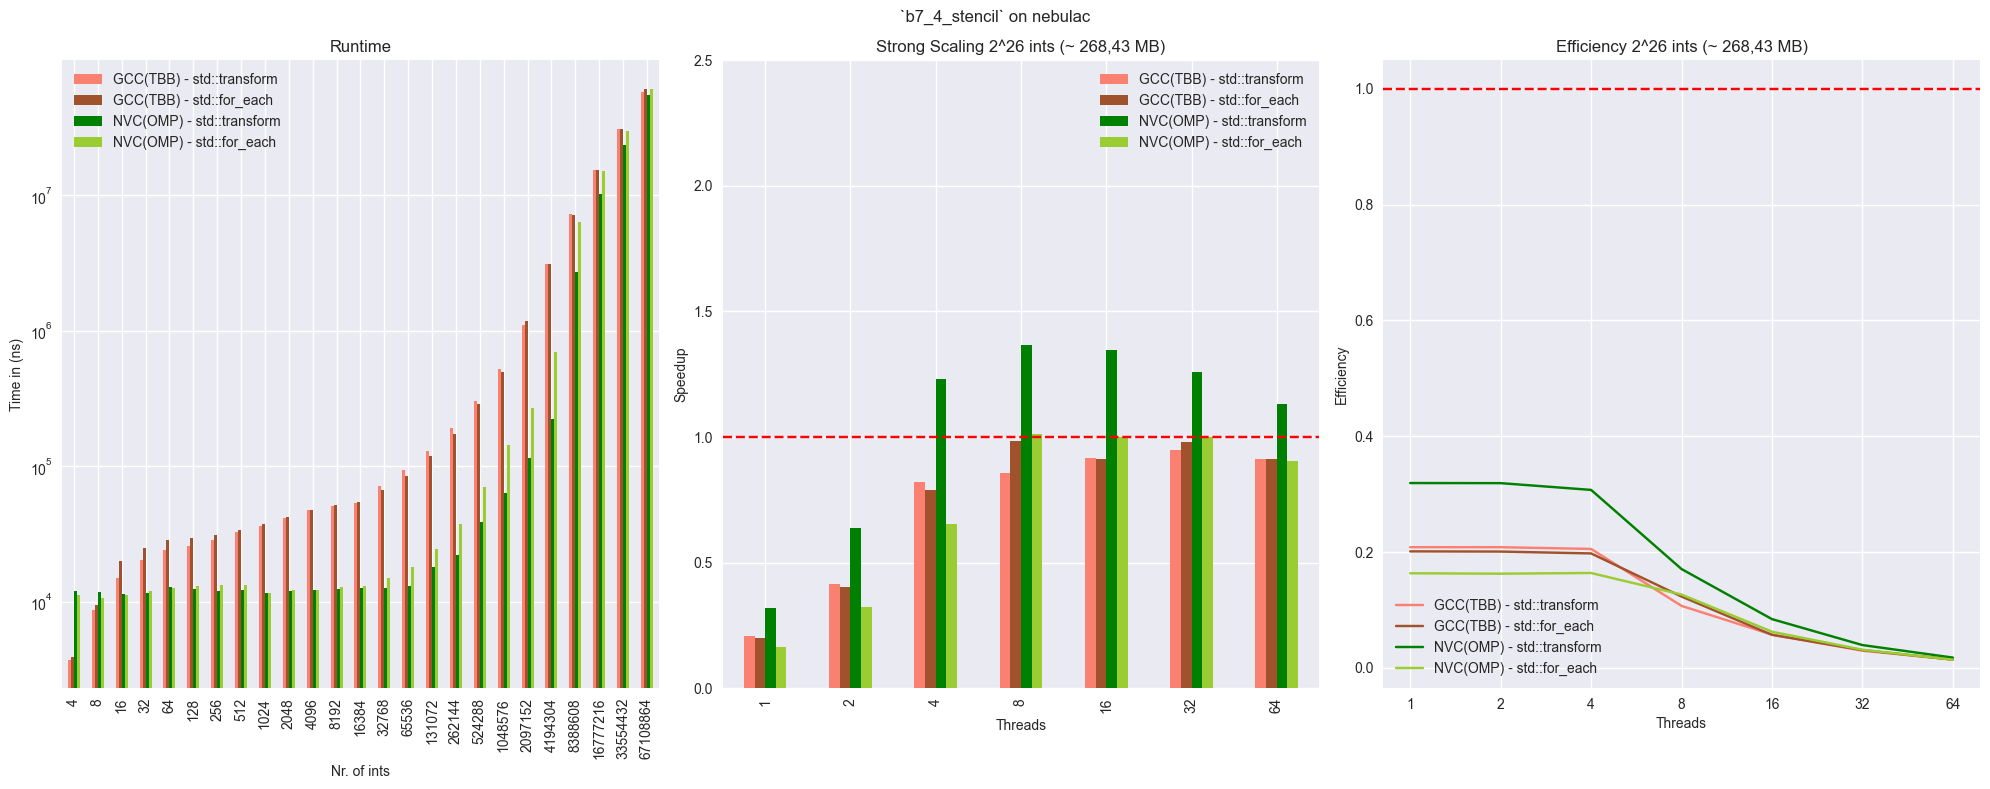

In [371]:
# graphs 

colorArray =[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(20, 8))


# plot runtime
ax_1 = b7_4_stencil_time_merged.plot(kind='bar',x='n',align='center',color=colorArray, ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=10)


# plot strong scaling
ax_2 = b7_4_stencil_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=colorArray,
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')

ax_2.set_ylim(0,2.5)



# plot efficiency
ax_3 = b7_4_stencil_efficiency.plot(x='threads',
                                                            color=colorArray,
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')


fig.suptitle(f"`b7_4_stencil` on {device_name}")

fig.tight_layout()

plot(f"`b7_4_stencil` {device_name}")

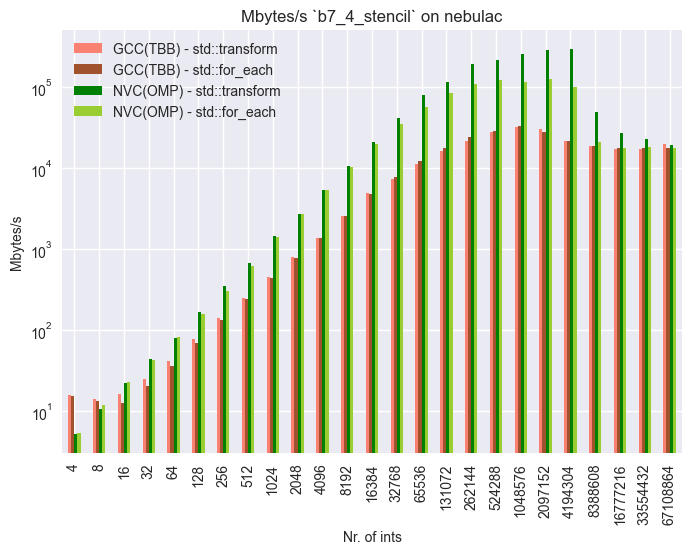

In [372]:

# mbytes graph

b7_4_stencil_bytes_merged.plot(kind='bar',
                       x='n',
                       color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]
                       )

plt.yscale('log',base=10)
plt.ylabel('Mbytes/s')
plt.xlabel('Nr. of ints')
plt.title(f'Mbytes/s `b7_4_stencil` on {device_name}')


plot(f'`b7_4_stencil` Mbytes_s on {device_name}')

## `b7_5` - Scalar Transform 

In [373]:
benchmark_names = [
    ("b7_5_scalar_transform_number",'std::transform'),
    ("b7_5_scalar_for_each",'std::for_each')
]

strong_scale_base = 'b7_5_scalar_transform_number'

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison -

Check how the runtime without constraining the threads develops with increasing input size

In [374]:
# collect data for instances
data = [
    par_data_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name 
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]

# merge for plotting
b7_5_scalar_transform_time_merged = data[0]

for i in range(1,len(data)):
    b7_5_scalar_transform_time_merged = pd.merge(b7_5_scalar_transform_time_merged,data[i], on='n')

b7_5_scalar_transform_time_merged

,GCC(TBB) - std::transform,n,GCC(TBB) - std::for_each,NVC(OMP) - std::transform,NVC(OMP) - std::for_each
0,5554.79,4,8748.47,12193.4,11802.6
1,13600.50,8,14907.90,12515.1,11711.2
2,19476.30,16,20993.00,12020.6,11701.6
3,24114.40,32,25198.60,12675.6,11983.0
4,26780.40,64,28553.50,12886.3,12880.5
5,30571.70,128,30311.00,12719.4,12478.5
6,31590.60,256,31749.40,13985.6,13642.7
7,32928.50,512,34382.60,13920.2,12227.2
8,34651.80,1024,36831.10,14110.7,11557.0
9,39484.20,2048,41650.20,13841.6,11414.1


### Strong Scaling -
 
2^26 fixed input size with threads 1-64

In [375]:
# collect data for instances
data = [
    get_strong_scaling_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name,
                  base_of=strong_scale_base
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]


# merge for plotting
b7_5_scalar_transform_strong_scaling_merged = data[0]

for i in range(1,len(data)):
    b7_5_scalar_transform_strong_scaling_merged = pd.merge(b7_5_scalar_transform_strong_scaling_merged,data[i], on='threads')


b7_5_scalar_transform_strong_scaling_merged

,threads,GCC(TBB) - std::transform,GCC(TBB) - std::for_each,NVC(OMP) - std::transform,NVC(OMP) - std::for_each
0,1,0.990269,0.422345,0.160742,0.083933
1,2,1.253421,0.681234,0.321379,0.167330
2,4,1.348303,0.876582,0.627197,0.300923
3,8,1.161279,0.770188,0.904920,0.556996
4,16,1.088656,0.781962,0.933142,0.624788
5,32,1.180351,0.788335,1.044184,0.683985
6,64,1.041704,0.728616,0.853710,0.610262


In [376]:
## efficiency graph

b7_5_scalar_transform_efficiency = b7_5_scalar_transform_strong_scaling_merged.copy()

for _,compiler_name in instances:
    for bench_name, display_name in benchmark_names:
        b7_5_scalar_transform_efficiency[f'{compiler_name} - {display_name}'] = b7_5_scalar_transform_efficiency[f'{compiler_name} - {display_name}'] / b7_5_scalar_transform_efficiency['threads']

b7_5_scalar_transform_efficiency

,threads,GCC(TBB) - std::transform,GCC(TBB) - std::for_each,NVC(OMP) - std::transform,NVC(OMP) - std::for_each
0,1,0.990269,0.422345,0.160742,0.083933
1,2,0.626710,0.340617,0.160689,0.083665
2,4,0.337076,0.219145,0.156799,0.075231
3,8,0.145160,0.096274,0.113115,0.069624
4,16,0.068041,0.048873,0.058321,0.039049
5,32,0.036886,0.024635,0.032631,0.021375
6,64,0.016277,0.011385,0.013339,0.009535


### Mbytes/s

In [377]:

# collect data for instances
data = [
    bytes_per_second_data_algo(compiler_location=comp_location,
                               compiler_name=f'{comp_name} - {display_name}',
                               benchmark_name=bench_name
                               )
    for comp_location, comp_name in instances
    for bench_name, display_name in benchmark_names
]

# merge for plotting
b7_5_scalar_transform_bytes_merged = data[0]

for i in range(1,len(data)):
    b7_5_scalar_transform_bytes_merged = pd.merge(b7_5_scalar_transform_bytes_merged,data[i], on='n')

b7_5_scalar_transform_bytes_merged

,n,GCC(TBB) - std::transform,GCC(TBB) - std::for_each,NVC(OMP) - std::transform,NVC(OMP) - std::for_each
0,4,5.69081,3.70406,2.66947,2.66237
1,8,4.66796,4.25123,5.32292,5.27159
2,16,6.50338,6.03741,10.57240,10.44630
3,32,10.50310,10.06340,20.14630,20.44980
4,64,18.94330,17.77320,39.69050,38.35770
5,128,33.15180,33.46900,83.01030,79.23790
6,256,64.14800,63.91390,178.13000,147.54600
7,512,123.15800,118.38000,348.52600,323.78700
8,1024,234.14200,220.62900,686.63100,681.95800
9,2048,411.31100,391.18600,1325.99000,1383.08000


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_11879/3247401511.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


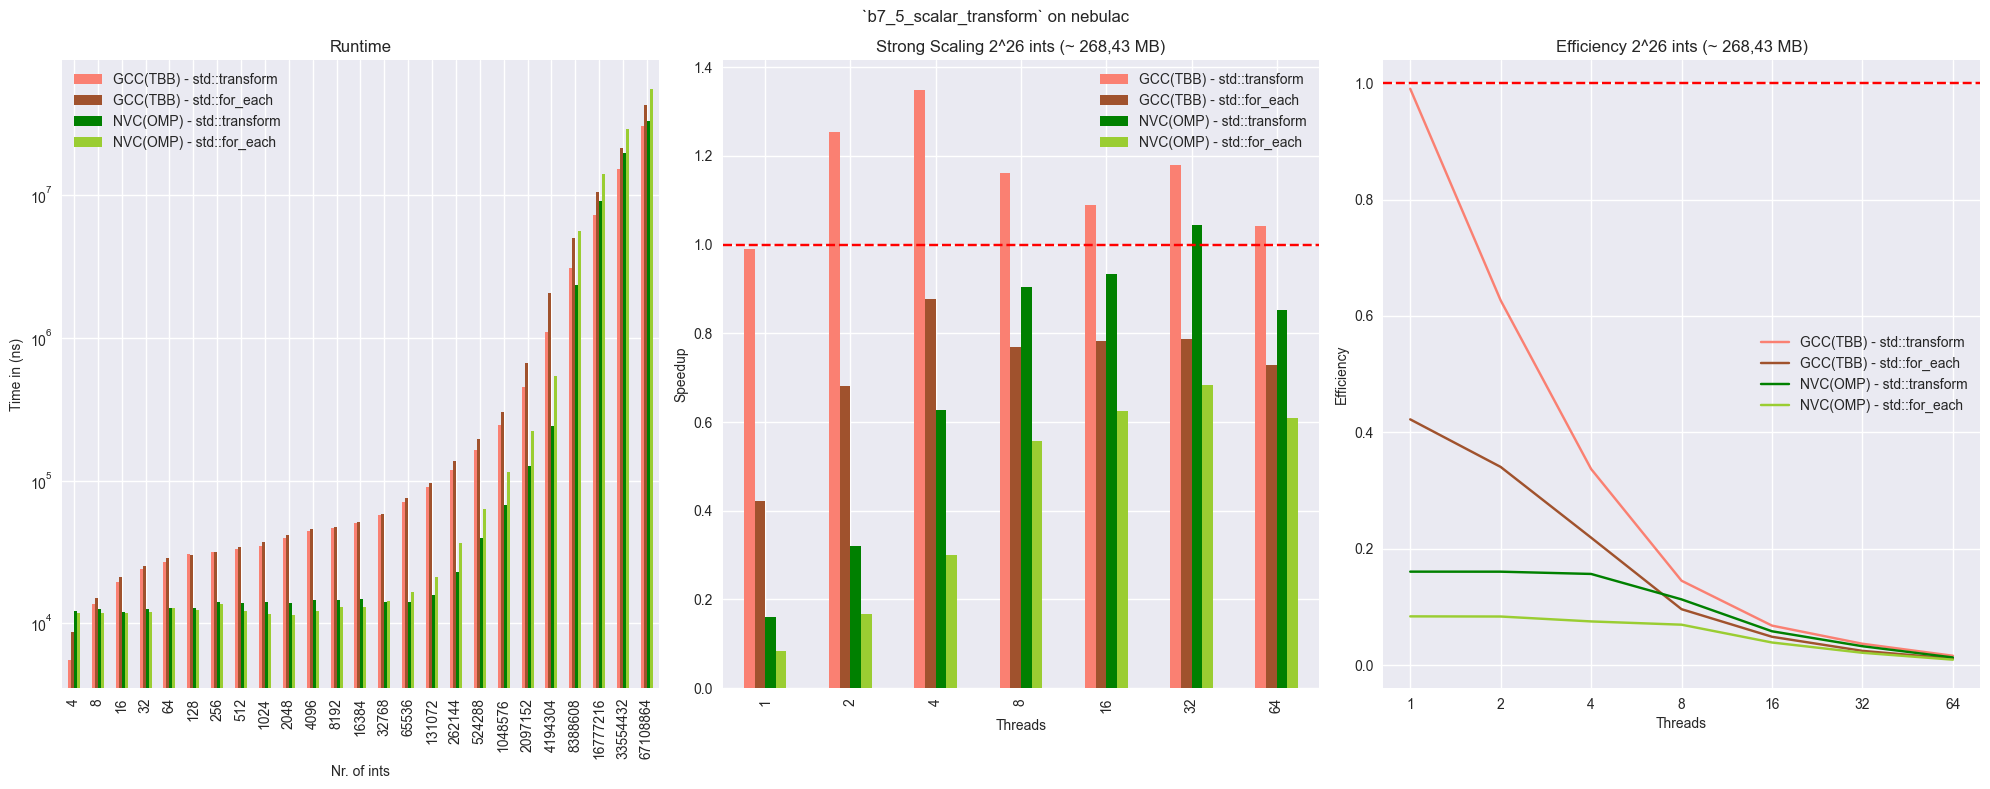

In [378]:
# graphs 

colorArray =[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(20, 8))


# plot runtime
ax_1 = b7_5_scalar_transform_time_merged.plot(kind='bar',x='n',align='center',color=colorArray, ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=10)


# plot strong scaling
ax_2 = b7_5_scalar_transform_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=colorArray,
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')




# plot efficiency
ax_3 = b7_5_scalar_transform_efficiency.plot(x='threads',
                                                            color=colorArray,
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')


fig.suptitle(f"`b7_5_scalar_transform` on {device_name}")

fig.tight_layout()

plot(f"`b7_5_scalar_transform` {device_name}")

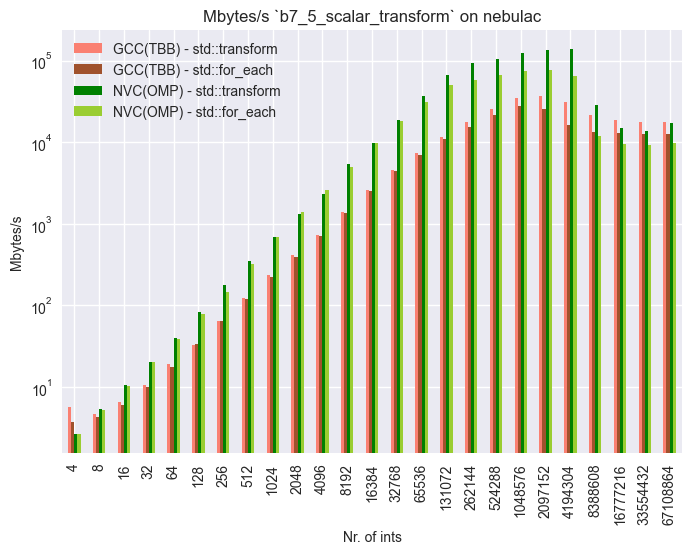

In [379]:

# mbytes graph

b7_5_scalar_transform_bytes_merged.plot(kind='bar',
                       x='n',
                       color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]
                       )

plt.yscale('log',base=10)
plt.ylabel('Mbytes/s')
plt.xlabel('Nr. of ints')
plt.title(f'Mbytes/s `b7_5_scalar_transform` on {device_name}')


plot(f'`b7_5_scalar_transform` Mbytes_s on {device_name}')

## `b7_6` - Serial vs direct call

In [380]:
benchmark_names = [
    ("b7_6_transform_reduce",'std::transform_reduce'),
    ("b7_6_serial_transform_reduce",'serial')
]

strong_scale_base = 'b7_6_transform_reduce'

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison -

Check how the runtime without constraining the threads develops with increasing input size

In [381]:
# collect data for instances
data = [
    par_data_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name 
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]

# merge for plotting
b7_6_transform_reduce_vs_serial_time_merged = data[0]

for i in range(1,len(data)):
    b7_6_transform_reduce_vs_serial_time_merged = pd.merge(b7_6_transform_reduce_vs_serial_time_merged,data[i], on='n')

b7_6_transform_reduce_vs_serial_time_merged

,GCC(TBB) - std::transform_reduce,n,GCC(TBB) - serial,NVC(OMP) - std::transform_reduce,NVC(OMP) - serial
0,5162.00,4,8.769680e+03,32015.9,36934.1
1,8769.28,8,1.710220e+04,20883.5,35987.7
2,14572.40,16,3.367500e+04,21447.5,36581.6
3,19528.10,32,4.545390e+04,21802.2,37731.1
4,21810.20,64,5.529500e+04,24043.2,39038.7
5,25927.40,128,6.178800e+04,25683.4,38412.8
6,27154.90,256,6.388270e+04,25771.6,38054.8
7,28627.90,512,6.542330e+04,24645.6,38930.1
8,31848.70,1024,7.118910e+04,22183.8,39984.6
9,34105.90,2048,8.086110e+04,23123.5,43610.4


### Strong Scaling -
 
2^26 fixed input size with threads 1-64

In [382]:
# collect data for instances
data = [
    get_strong_scaling_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name ,
                  base_of=strong_scale_base
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]


# merge for plotting
b7_6_transform_reduce_vs_serial_strong_scaling_merged = data[0]

for i in range(1,len(data)):
    b7_6_transform_reduce_vs_serial_strong_scaling_merged = pd.merge(b7_6_transform_reduce_vs_serial_strong_scaling_merged,data[i], on='threads')


b7_6_transform_reduce_vs_serial_strong_scaling_merged

,threads,GCC(TBB) - std::transform_reduce,GCC(TBB) - serial,NVC(OMP) - std::transform_reduce,NVC(OMP) - serial
0,1,0.991316,0.450853,0.788794,0.230150
1,2,1.825229,0.593442,1.425712,0.402338
2,4,2.185609,0.625697,1.762663,0.538166
3,8,1.662446,0.472605,1.601784,0.538879
4,16,1.809644,0.477726,1.230313,0.433503
5,32,1.789812,0.483396,1.020044,0.412444
6,64,1.783082,0.462073,1.094968,0.332491


In [383]:
## efficiency graph

b7_6_transform_reduce_vs_serial_efficiency = b7_6_transform_reduce_vs_serial_strong_scaling_merged.copy()

for _,compiler_name in instances:
    for bench_name, display_name in benchmark_names:
        b7_6_transform_reduce_vs_serial_efficiency[f'{compiler_name} - {display_name}'] = b7_6_transform_reduce_vs_serial_efficiency[f'{compiler_name} - {display_name}'] / b7_6_transform_reduce_vs_serial_efficiency['threads']

b7_6_transform_reduce_vs_serial_efficiency

,threads,GCC(TBB) - std::transform_reduce,GCC(TBB) - serial,NVC(OMP) - std::transform_reduce,NVC(OMP) - serial
0,1,0.991316,0.450853,0.788794,0.230150
1,2,0.912614,0.296721,0.712856,0.201169
2,4,0.546402,0.156424,0.440666,0.134542
3,8,0.207806,0.059076,0.200223,0.067360
4,16,0.113103,0.029858,0.076895,0.027094
5,32,0.055932,0.015106,0.031876,0.012889
6,64,0.027861,0.007220,0.017109,0.005195


### Mbytes/s   

In [384]:

# collect data for instances
data = [
    bytes_per_second_data_algo(compiler_location=comp_location,
                               compiler_name=f'{comp_name} - {display_name}',
                               benchmark_name=bench_name
                               )
    for comp_location, comp_name in instances
    for bench_name, display_name in benchmark_names
]

# merge for plotting
b7_6_transform_reduce_vs_serial_bytes_merged = data[0]

for i in range(1,len(data)):
    b7_6_transform_reduce_vs_serial_bytes_merged = pd.merge(b7_6_transform_reduce_vs_serial_bytes_merged,data[i], on='n')

b7_6_transform_reduce_vs_serial_bytes_merged

,n,GCC(TBB) - std::transform_reduce,GCC(TBB) - serial,NVC(OMP) - std::transform_reduce,NVC(OMP) - serial
0,4,6.21534,10.9394,1.12100,2.59421
1,8,7.31065,11.4061,3.06321,5.30472
2,16,8.70542,11.3708,5.96278,10.42500
3,32,13.02390,16.8685,11.75290,20.22640
4,64,23.21190,27.7711,21.47390,39.12540
5,128,39.30030,49.7604,40.02030,79.50650
6,256,74.71720,96.3351,79.59270,160.44800
7,512,141.77800,187.7400,166.99200,313.04600
8,1024,255.47800,345.0710,368.96000,610.57200
9,2048,476.74600,607.4510,711.74600,1118.83000


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_11879/182734503.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


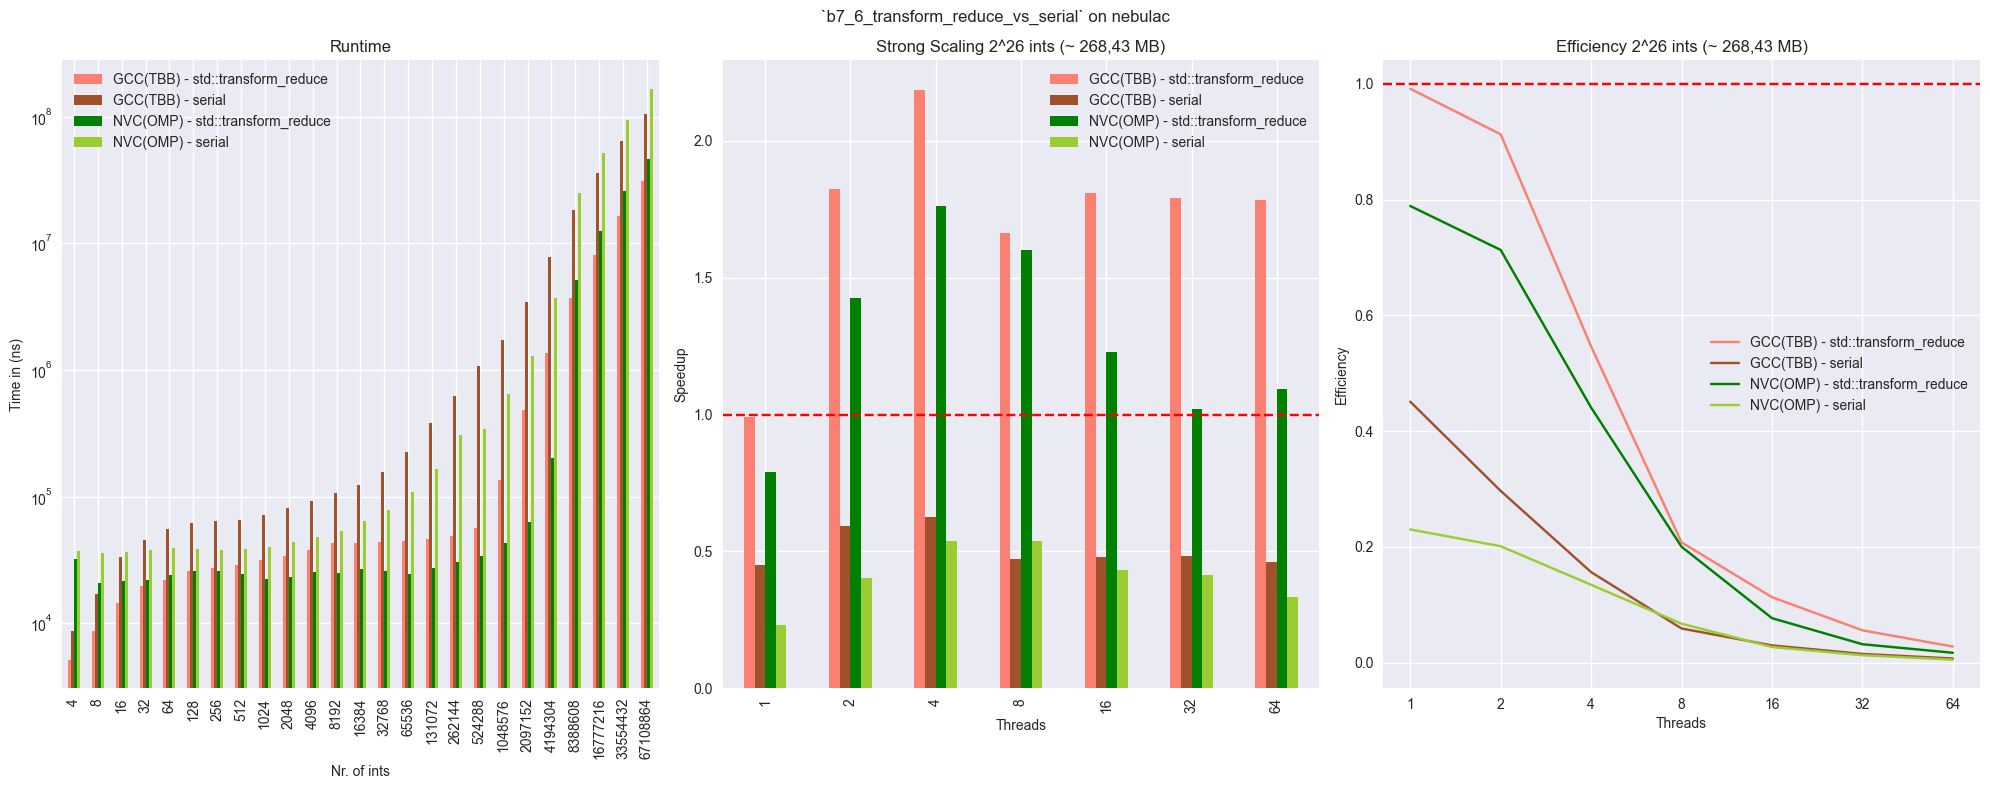

In [385]:
# graphs 

colorArray =[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(20, 8))


# plot runtime
ax_1 = b7_6_transform_reduce_vs_serial_time_merged.plot(kind='bar',x='n',align='center',color=colorArray, ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=10)


# plot strong scaling
ax_2 = b7_6_transform_reduce_vs_serial_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=colorArray,
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')





# plot efficiency
ax_3 = b7_6_transform_reduce_vs_serial_efficiency.plot(x='threads',
                                                            color=colorArray,
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')


fig.suptitle(f"`b7_6_transform_reduce_vs_serial` on {device_name}")

fig.tight_layout()

plot(f"`b7_6_transform_reduce_vs_serial` {device_name}")

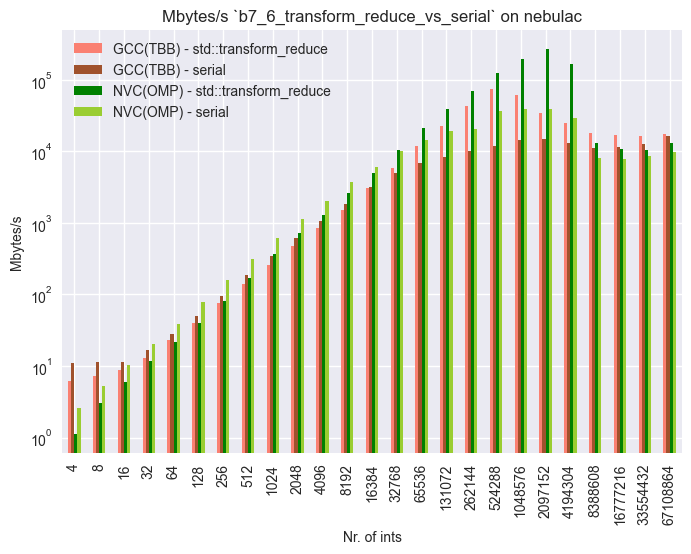

In [386]:
# mbytes graph

b7_6_transform_reduce_vs_serial_bytes_merged.plot(kind='bar',
                       x='n',
                       color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]
                       )

plt.yscale('log',base=10)
plt.ylabel('Mbytes/s')
plt.xlabel('Nr. of ints')
plt.title(f'Mbytes/s `b7_6_transform_reduce_vs_serial` on {device_name}')


plot(f'`b7_6_transform_reduce_vs_serial` Mbytes_s on {device_name}')

######################## DIVIDER ########################

## Performance Portability Calculation (Inter Compiler)

Runtime

In [387]:
# calc pp_metrics

def calc_pp(data_points:List[int]) -> int:
    min_val = min(data_points)
    return len(data_points) / sum([1/(min_val/val) for val in data_points])

compilers = ['GCC(TBB)','NVC(OMP)']

pp_df = pd.DataFrame(columns=['name','GCC(TBB)','NVC(OMP)','PP'])


data_fields = [
    ('b7_1_copy',b7_1_time_merged, [' - std::copy', ' - std::foreach']),
    
    ('b7_2_all_of_all_true',b7_2_time_merged, [' - std::all_of', ' - std::transform_reduce']),
    ('b7_2_all_of_first_false',b7_2_first_false_time_merged, [' - std::all_of', ' - std::transform_reduce']),
    ('b7_2_all_of_last_false',b7_2_last_false_time_merged, [' - std::all_of', ' - std::transform_reduce']),
    ('b7_2_all_of_auto_false',b7_2_auto_false_time_merged, [' - std::all_of', ' - std::transform_reduce']),


    ('b7_3_count_if_all_hit',b7_3_all_hit_time_merged, [' - std::count_if', ' - std::transform_reduce']),
    ('b7_3_count_if_half_hit',b7_3_half_hit_time_merged, [' - std::count_if', ' - std::transform_reduce']),
    ('b7_3_count_if_orders_struct',b7_3_orders_struct_time_merged, [' - std::count_if', ' - std::transform_reduce']),

    
    ('b7_4_stencil_transform',b7_4_stencil_time_merged, [' - std::transform', ' - std::for_each']),


    ('b7_5_scalar_transform',b7_5_scalar_transform_time_merged, [' - std::transform', ' - std::for_each']),


    ('b7_6_transform_reduce',b7_6_transform_reduce_vs_serial_time_merged, [' - std::transform_reduce', ' - serial']),
]


for root_display_name, data_source, suffixes in data_fields:

    for suffix in suffixes:
        entry_dict = {
            'name': [root_display_name + suffix],
        }

        vals = []

        # getting the data from the source for each compiler
        for comp in compilers:
            current_val = int(data_source.iloc[-1][comp + suffix])
            entry_dict[comp] = [current_val]

            vals.append(current_val)

        entry_dict['PP'] = calc_pp(vals)

        other_df = pd.DataFrame.from_dict(entry_dict)
        pp_df = pd.concat([pp_df,other_df],ignore_index=True)



pp_df['Percentage'] = pp_df['PP']

pp_df['INTERPRET'] = np.where(pp_df['PP']>0.85, 'GOOD', 'BAD')


pp_df = pp_df.style.format({'Percentage': "{:.2%}"})
pp_df

,name,GCC(TBB),NVC(OMP),PP,Percentage,INTERPRET
0,b7_1_copy - std::copy,29617400,38619600,0.868075,86.81%,GOOD
1,b7_1_copy - std::foreach,30467600,38754800,0.880282,88.03%,GOOD
2,b7_2_all_of_all_true - std::all_of,10800300,20574200,0.688476,68.85%,BAD
3,b7_2_all_of_all_true - std::transform_reduce,10728900,17199800,0.768306,76.83%,BAD
4,b7_2_all_of_first_false - std::all_of,22592,65019,0.515734,51.57%,BAD
5,b7_2_all_of_first_false - std::transform_reduce,10238000,17367600,0.741734,74.17%,BAD
6,b7_2_all_of_last_false - std::all_of,7458950,20189200,0.539562,53.96%,BAD
7,b7_2_all_of_last_false - std::transform_reduce,10204700,17538300,0.735659,73.57%,BAD
8,b7_2_all_of_auto_false - std::all_of,21915,48067,0.626304,62.63%,BAD
9,b7_2_all_of_auto_false - std::transform_reduce,182224,23312,0.226841,22.68%,BAD


## Findings for H7

### XXX

### General


### GPU Findings


### Hypothesis Findings


